# Import Files

In [1]:
from os import listdir
from os.path import isfile, join
mypath = "../images"
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(str(len(file_names)) + ' images loaded')

93 images loaded


In [2]:
file_names[0]

'cat1.jpg'

In [ ]:
file_names
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.applications.resnet50 import preprocess_input

# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from keras.applications.resnet50 import preprocess_input

import matplotlib.pyplot as plt
import numpy as np

import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.applications.resnet50 import preprocess_input

# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from keras.applications.resnet50 import preprocess_input

import matplotlib.pyplot as plt
import numpy as np

import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Preprocess Image

In [5]:
#function to preprocess normal image 
def prepocessImage(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    frame = img
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    sensitivity = 156
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)
    ret, thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)
    circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 1.5, 100000,param1=80,param2=40,minRadius=0,maxRadius=0)
    x,y,r = 0,0,0
    if circles is not None:
      circles = np.uint16(np.around(circles))
      x,y,r = circles[0][0]
      x=int(x)
      y=int(y)
      r=int(r)
    mask = np.zeros((224,224), np.uint8)
    cv2.circle(mask,(x,y),r,(255,255,255),-1)
    masked_data = cv2.bitwise_and(frame, frame, mask=mask)
    _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
    cnt = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    x,y,w,h = cv2.boundingRect(cnt[0])

    # Crop masked_data
    crop = masked_data[y:y+h,x:x+w]
    crop = cv2.resize(crop, (224,224), interpolation = cv2.INTER_AREA)
    #preprocess the image
    my_image = preprocess_input(crop)
    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
#     my_image = img_to_array(crop)
#     plt.imshow(my_image)
#     my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#     return my_image
    # preprocessed shape = (1,224,224,1)
    return crop

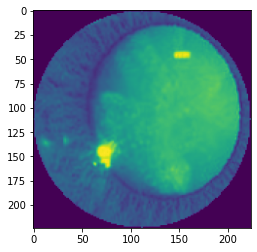

In [6]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
plt.imshow(prepocessImage("../images/"+file_names[21]))

In [7]:
cv2.imread("../images/"+file_names[0])

array([[[172, 191, 234],
        [170, 191, 236],
        [167, 189, 237],
        ...,
        [106, 134, 195],
        [105, 133, 194],
        [104, 132, 193]],

       [[173, 192, 235],
        [171, 192, 237],
        [167, 189, 237],
        ...,
        [106, 134, 195],
        [105, 133, 194],
        [104, 132, 193]],

       [[172, 193, 238],
        [170, 193, 239],
        [167, 190, 238],
        ...,
        [106, 134, 195],
        [105, 133, 194],
        [104, 132, 193]],

       ...,

       [[110, 151, 214],
        [110, 151, 214],
        [110, 151, 214],
        ...,
        [121, 159, 223],
        [122, 160, 224],
        [118, 156, 220]],

       [[110, 151, 214],
        [110, 151, 214],
        [110, 151, 214],
        ...,
        [123, 161, 225],
        [124, 162, 226],
        [120, 158, 222]],

       [[110, 151, 214],
        [110, 151, 214],
        [110, 151, 214],
        ...,
        [125, 163, 227],
        [126, 164, 228],
        [122, 160, 224]]

# Sift and Glcm 

In [56]:
import cv2
import numpy as np
from skimage.feature import  graycomatrix, graycoprops
images_sift = []
glcm=[]
labels = []
size = 128
sift = cv2.SIFT_create()
cataract=0
normal=0
for i, file in enumerate(file_names):
        image = cv2.imread(mypath+"/"+file,0)
        h,w=image.shape
#         if(h>128 and w>128):
        image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
        img_arr = np.array(image)
        gCoMat = graycomatrix(img_arr, [1], [0],256,symmetric=True, normed=True) # Co-occurance matrix
        contrast = graycoprops(gCoMat, prop='contrast')[0][0]
        dissimilarity = graycoprops(gCoMat, prop='dissimilarity')[0][0]
        homogeneity = graycoprops(gCoMat, prop='homogeneity')[0][0]
        energy = graycoprops(gCoMat, prop='energy')[0][0]
        correlation = graycoprops(gCoMat, prop='correlation')[0][0]
        keypoints, descriptors = sift.detectAndCompute(image,None)
        descriptors=np.array(descriptors)
        descriptors=descriptors.flatten()
        glcm.append([contrast,dissimilarity,homogeneity,energy,correlation])
        images_sift.append(descriptors[:2304])

        #print(descriptors.shape)
        if file_names[i][0] == "c":
            cataract+=1
            labels.append(1)
        if file_names[i][0] == "n":
            normal+=1
            labels.append(0)

print("Testing and validation split done!")


Testing and validation split done!


In [9]:
# images_sift

In [57]:
images_sift=np.array(images_sift)
images_sift.shape

(93, 2304)

In [11]:
glcm=np.array(glcm)
images_sift_glcm=np.concatenate((images_sift,glcm),axis=1)
images_sift_glcm.shape

(93, 2309)

In [12]:
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import confusion_matrix  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


rf_class = RandomForestClassifier(n_estimators=100, criterion='entropy',max_features='sqrt', max_depth=3, n_jobs=2,
random_state=1337)
svm_poly=svm.SVC(kernel='poly',gamma=0.1,C=10)
knn= KNeighborsClassifier(n_neighbors=6, metric='minkowski', p=2) 
log = LogisticRegression(solver='saga',penalty='l1')

model_names={"Random Forest":rf_class,"SVM":svm_poly,"k nearest neighbor":knn,"logistic regression":log}

In [13]:
def testing(model_name,X_train, X_test, y_train, y_test):
    model=model_names[model_name]
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    # evaluate predictions
    acc = accuracy_score(y_test, yhat)
    print(model_name,'\tAccuracy: %.3f' % acc)
    print(confusion_matrix(y_test, yhat))
    print("\n\n")

In [14]:
def result(dataset):
    #Normalization
    #min_max_scaler = preprocessing.StandardScaler()
    #x_scaled = min_max_scaler.fit_transform(dataset)
    
    
    #panda dataframe 
    df=pd.DataFrame(data=dataset)
    df['label']=labels
    df=df.sample(frac=1)
    X=df.drop(['label'], axis = 1)
    y=df['label']
    
    
    #Different model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
    for model in ["Random Forest","SVM","k nearest neighbor","logistic regression"]:
        testing(model,X_train, X_test, y_train, y_test)

In [15]:
print("Sift testing..........\n")
result(images_sift)

Sift testing..........

Random Forest 	Accuracy: 0.750
[[ 8  1]
 [ 5 10]]



SVM 	Accuracy: 0.792
[[ 8  1]
 [ 4 11]]



k nearest neighbor 	Accuracy: 0.875
[[ 8  1]
 [ 2 13]]



logistic regression 	Accuracy: 0.833
[[ 8  1]
 [ 3 12]]





c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [16]:
print("glcm testing..........\n")
result(glcm)

glcm testing..........

Random Forest 	Accuracy: 0.542
[[7 6]
 [5 6]]



SVM 	Accuracy: 0.667
[[11  2]
 [ 6  5]]



k nearest neighbor 	Accuracy: 0.375
[[5 8]
 [7 4]]



logistic regression 	Accuracy: 0.625
[[11  2]
 [ 7  4]]





c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [17]:
print("sift and glcm combined testing..........\n")
result(images_sift_glcm)

sift and glcm combined testing..........

Random Forest 	Accuracy: 0.667
[[ 4  8]
 [ 0 12]]



SVM 	Accuracy: 0.750
[[ 6  6]
 [ 0 12]]



k nearest neighbor 	Accuracy: 0.750
[[ 6  6]
 [ 0 12]]



logistic regression 	Accuracy: 0.750
[[ 6  6]
 [ 0 12]]





c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


# RF

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(12,10)})

In [20]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
df=pd.DataFrame(data=images_sift)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with max features = 1 and max_depth = None: 0.792
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.667
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.750
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.583
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.708
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.833
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.917
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.875
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.833
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.833
Classification accuracy on test set with max features = log2 and max_depth = None: 0.750
Classification accuracy on test set with max features = log2

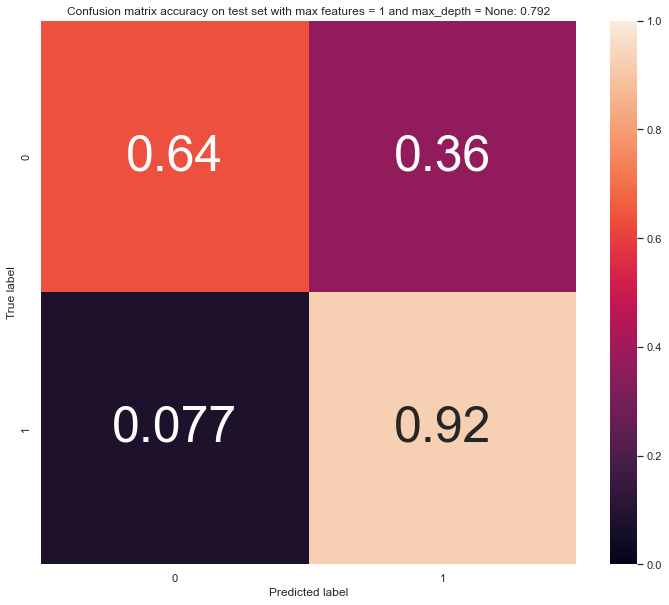

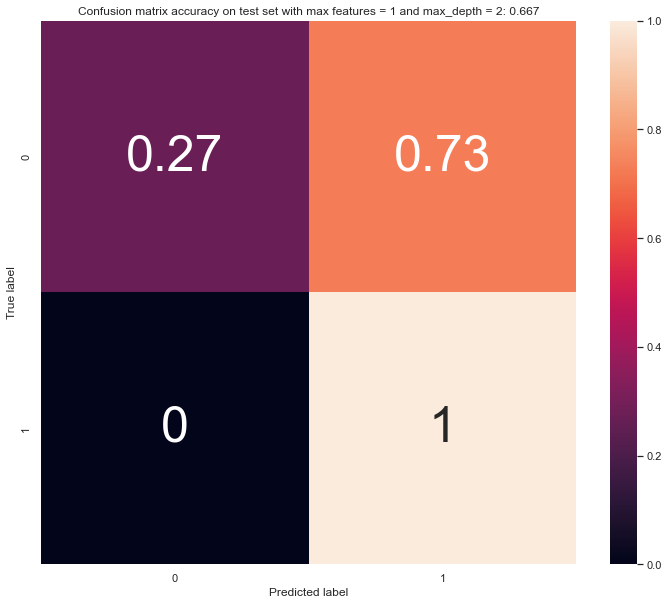

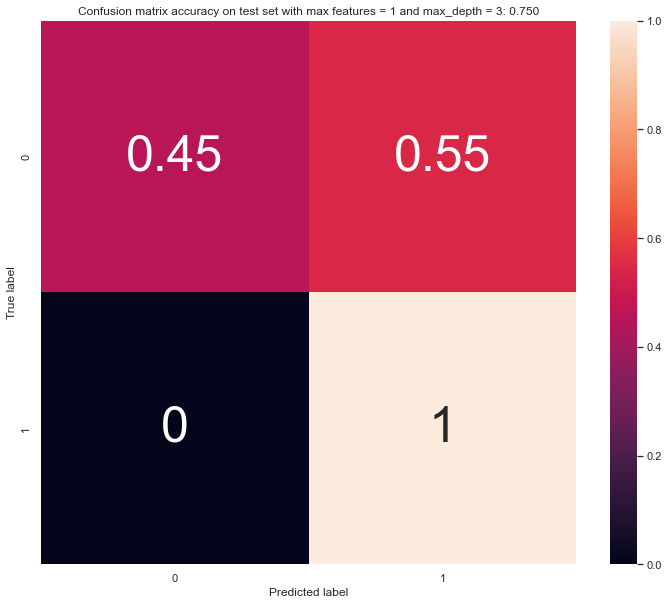

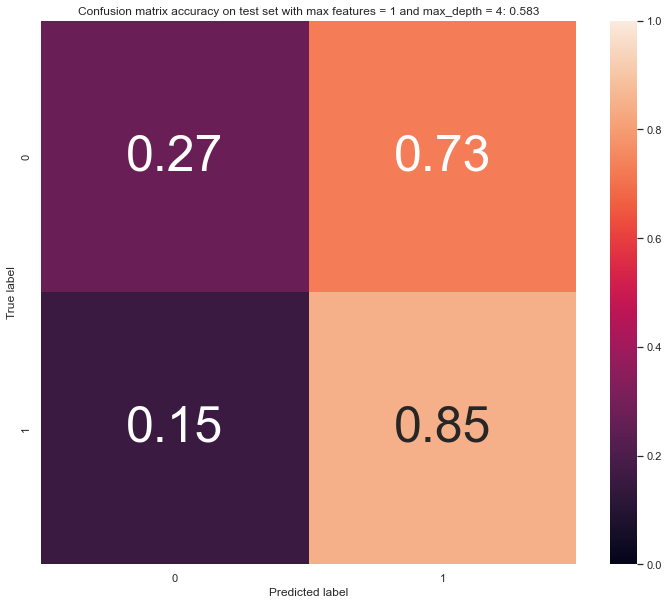

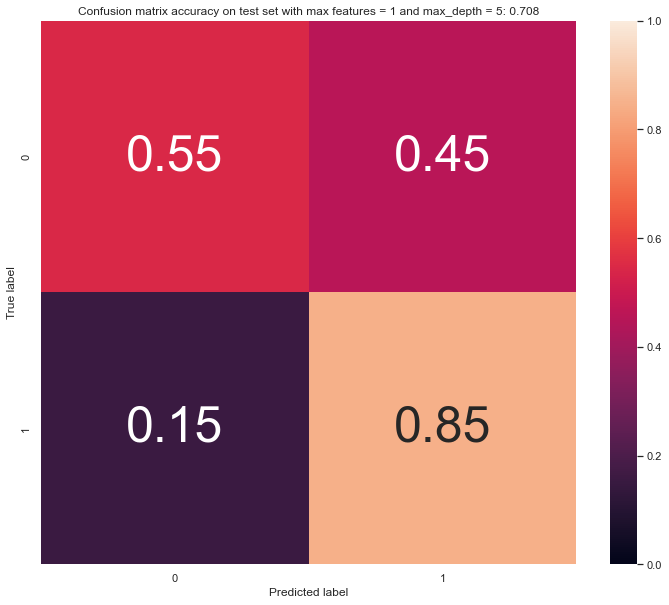

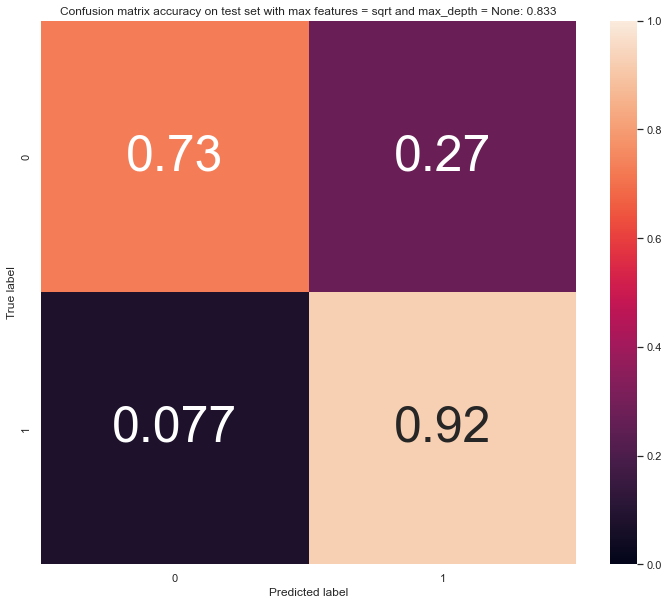

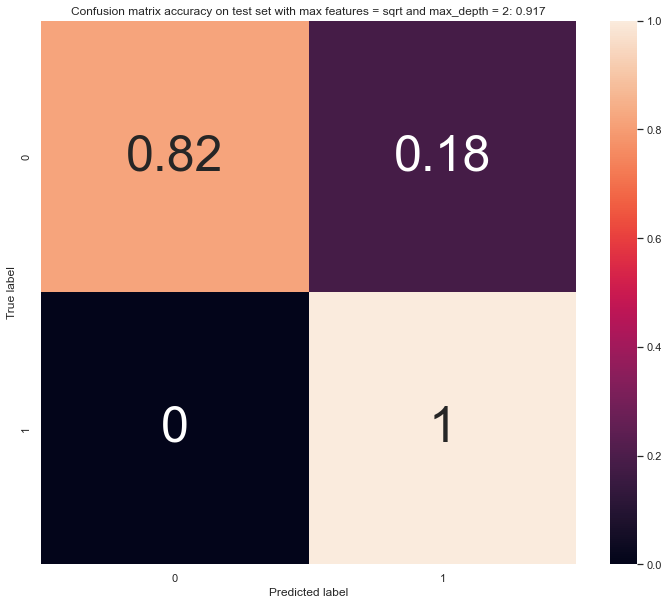

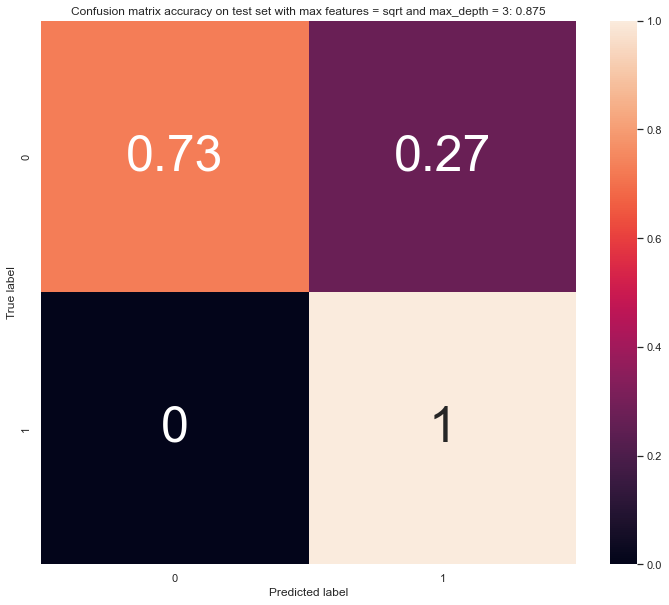

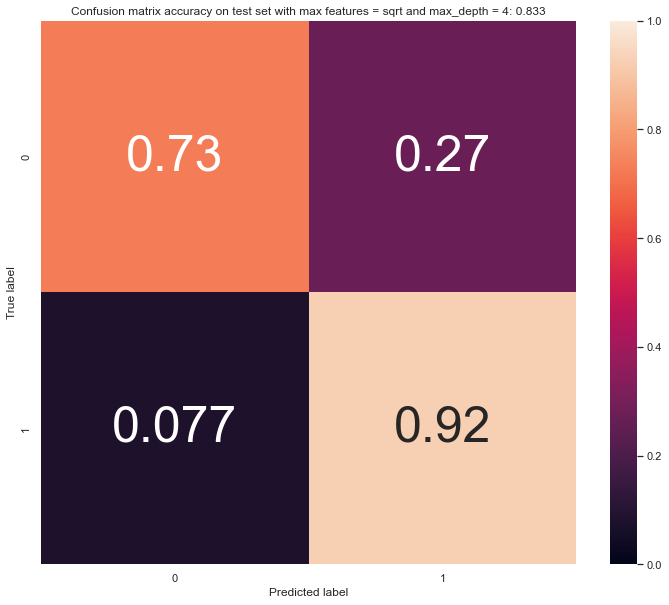

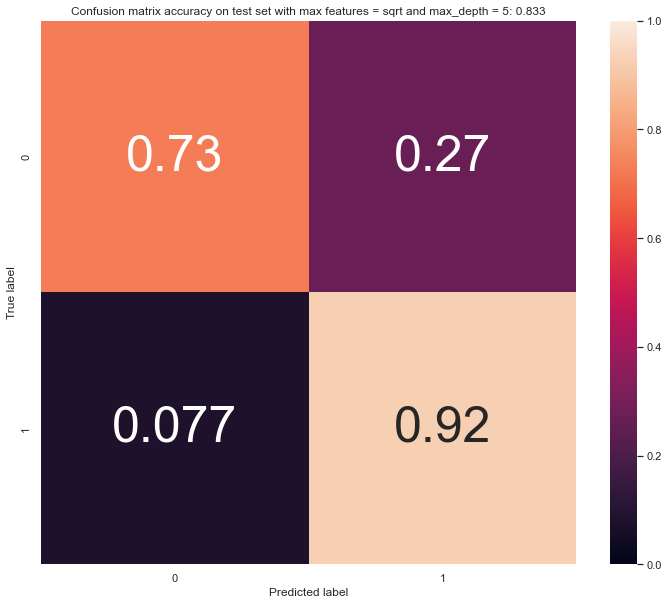

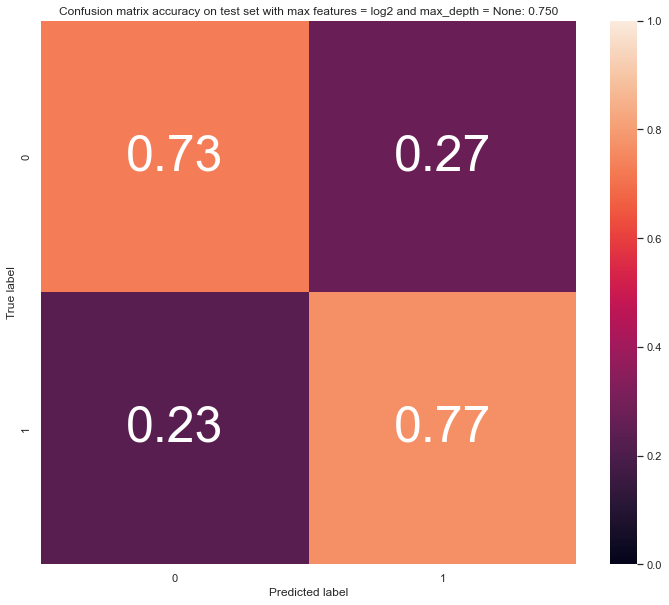

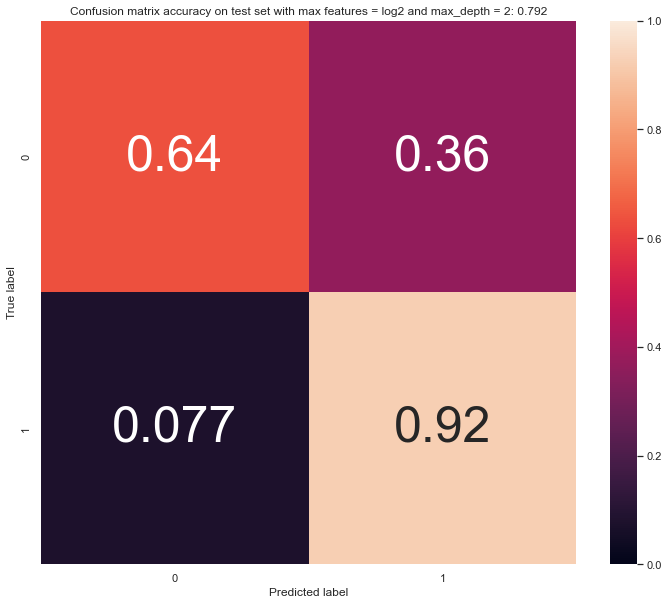

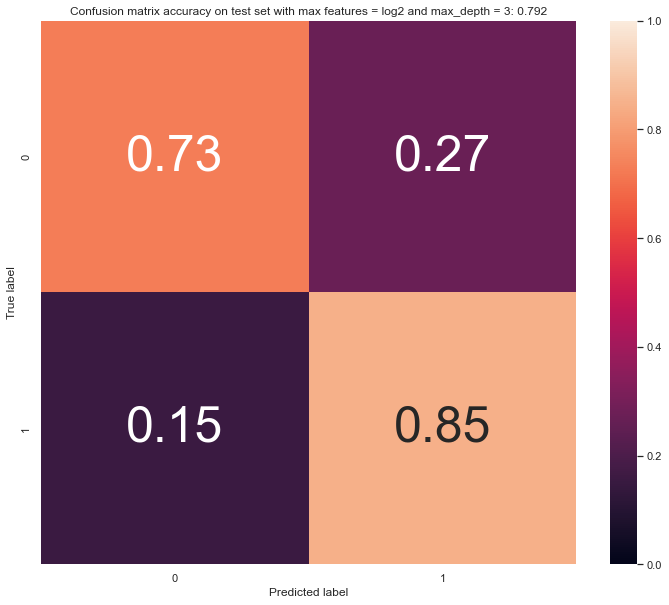

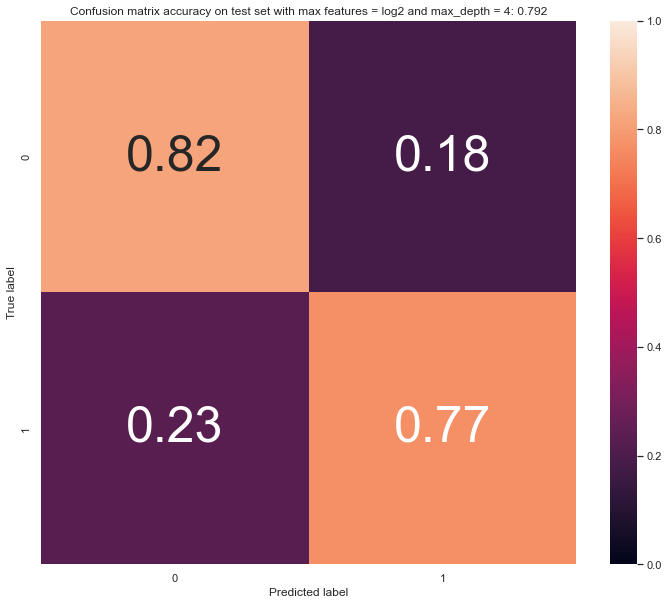

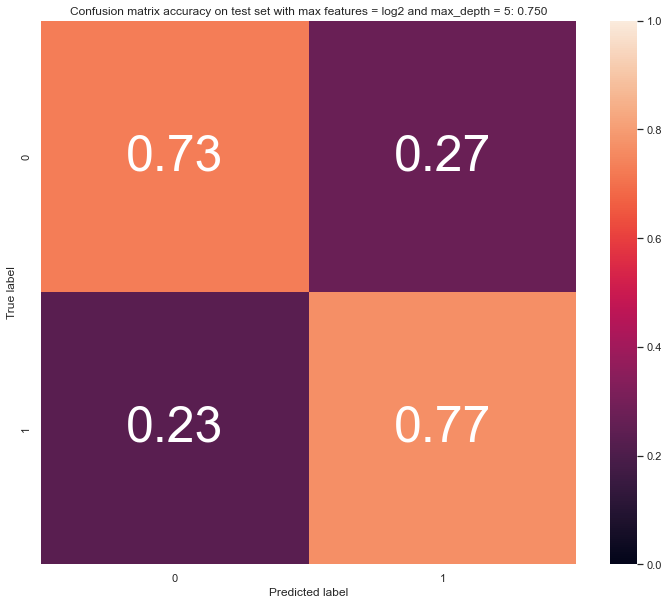

In [22]:
from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

In [23]:
df=pd.DataFrame(data=glcm)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with max features = 1 and max_depth = None: 0.542
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.708
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.625
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.583
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.542
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.542
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.708
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.667
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.542
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.583
Classification accuracy on test set with max features = log2 and max_depth = None: 0.542
Classification accuracy on test set with max features = log2

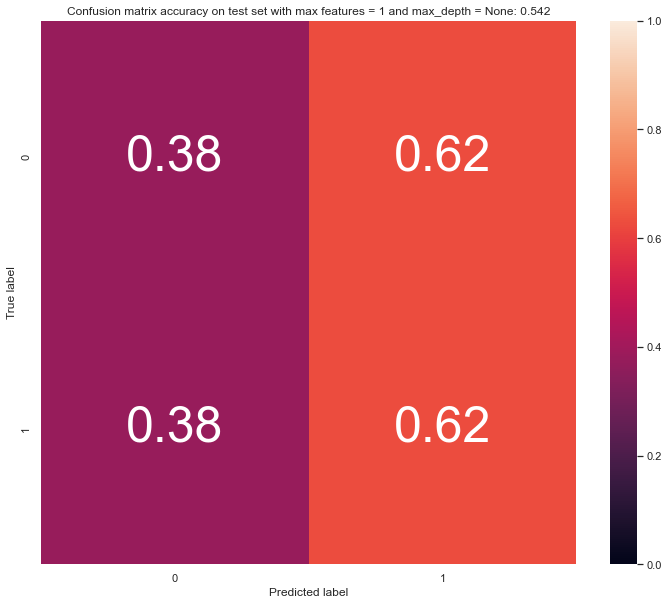

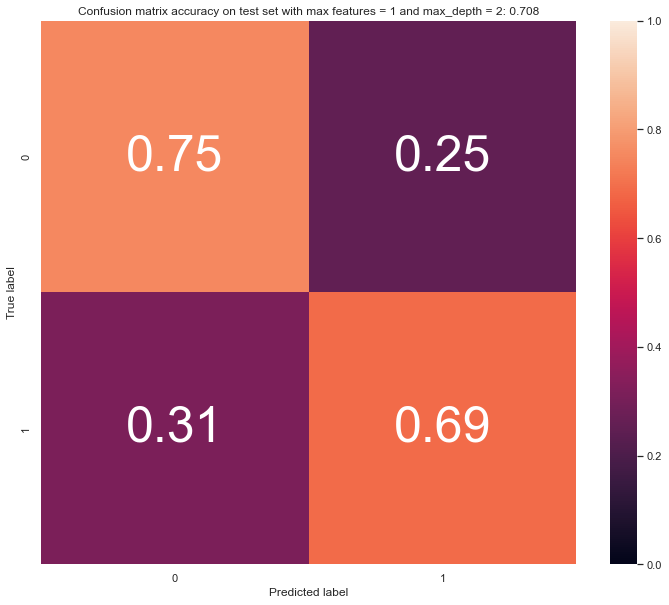

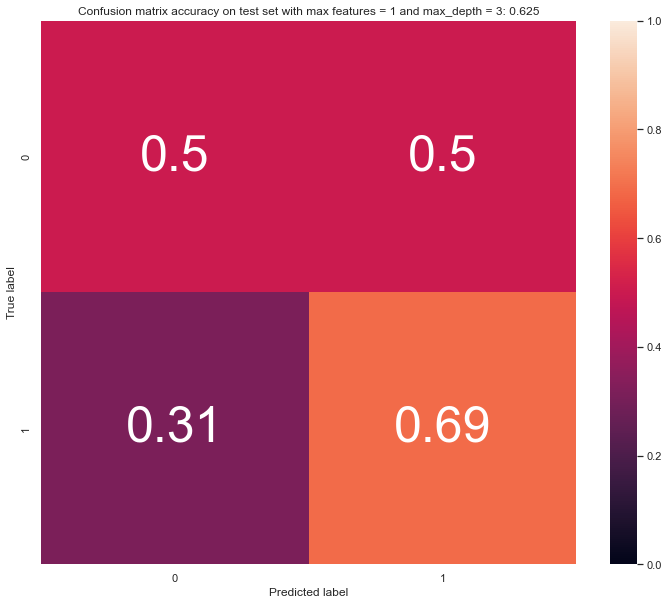

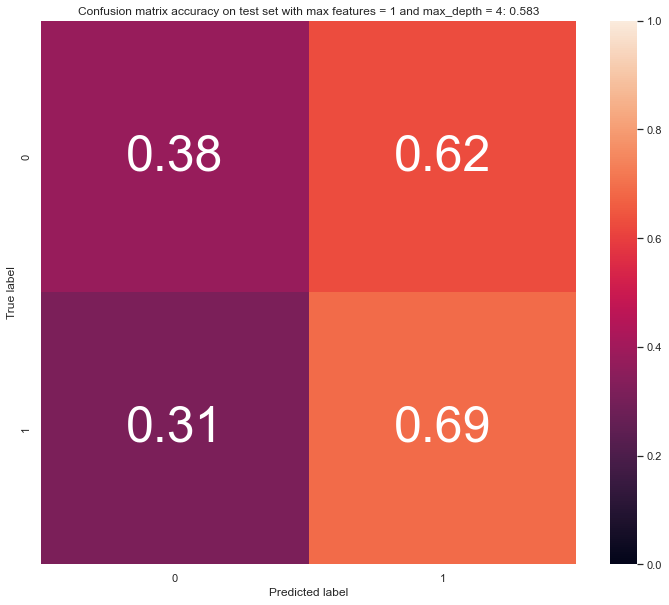

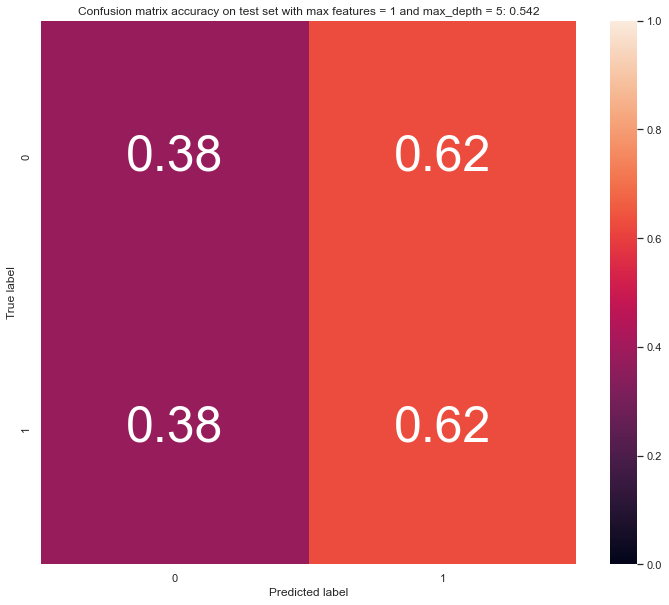

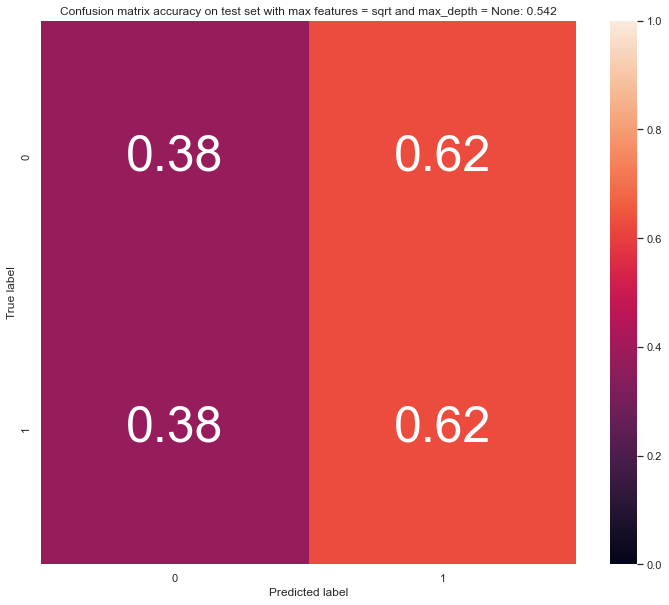

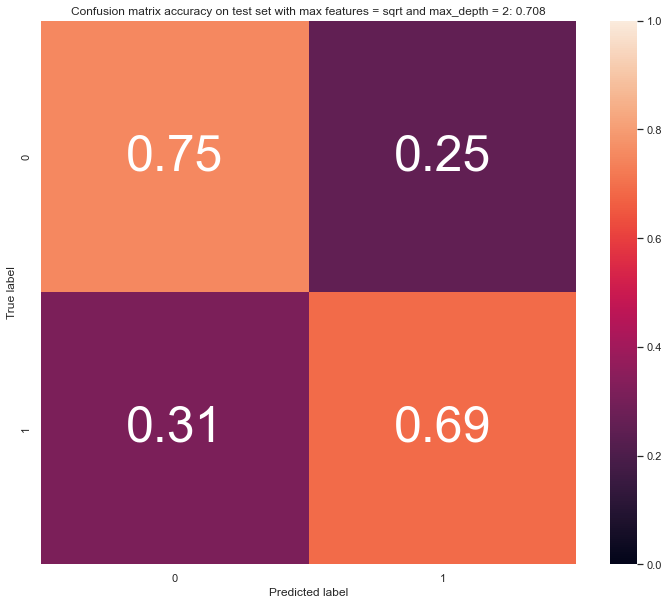

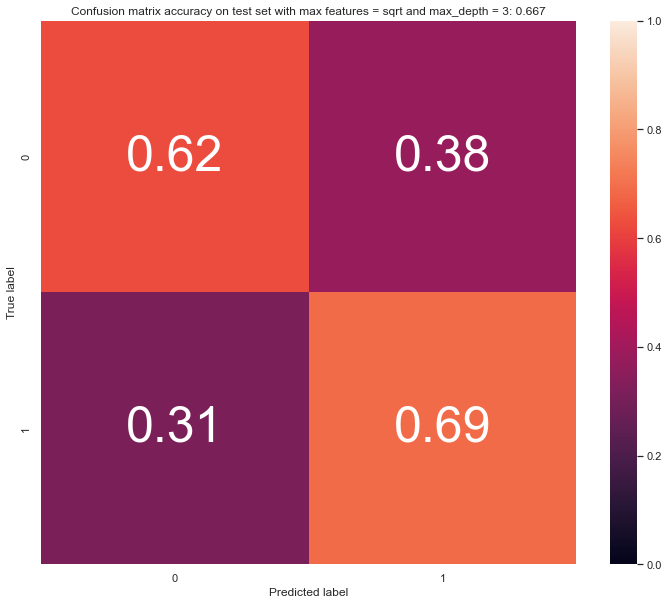

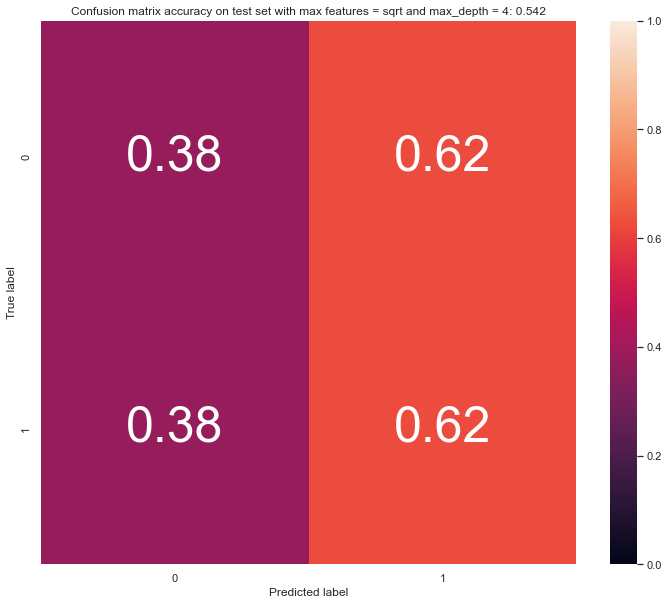

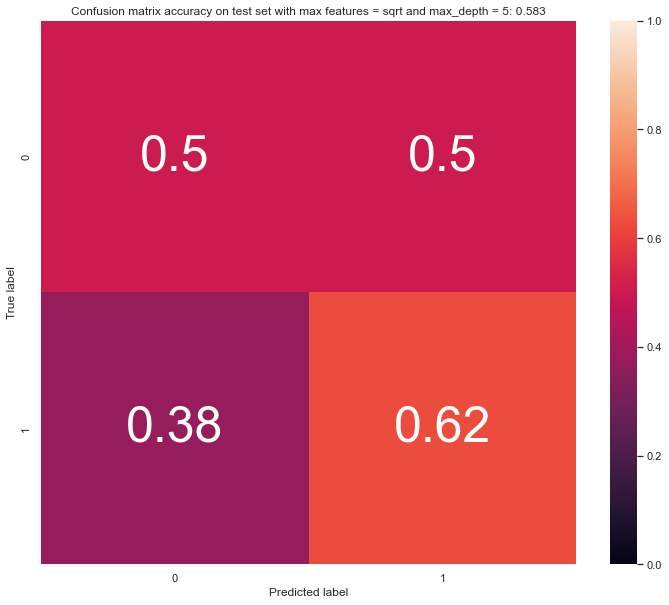

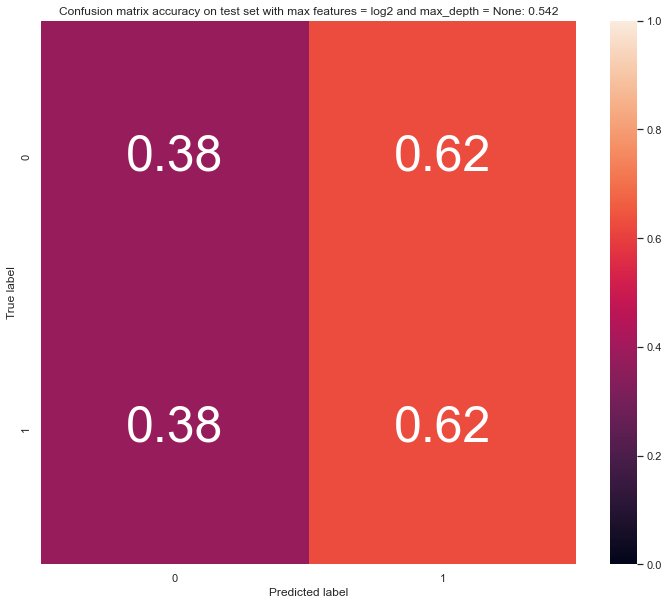

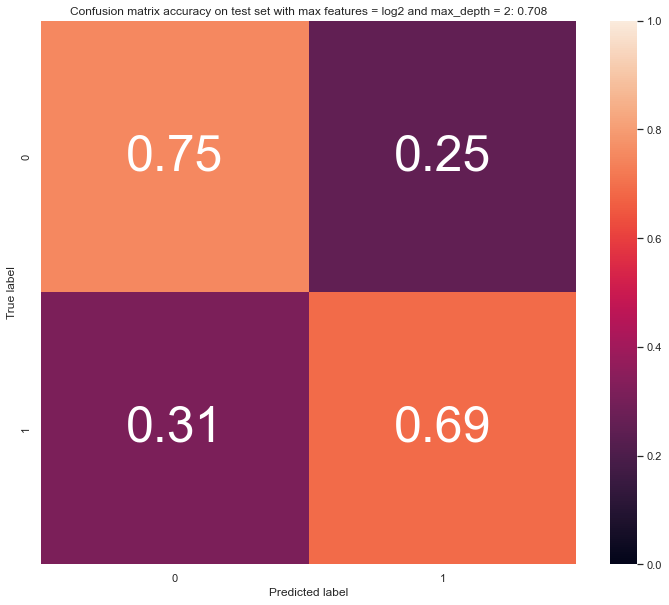

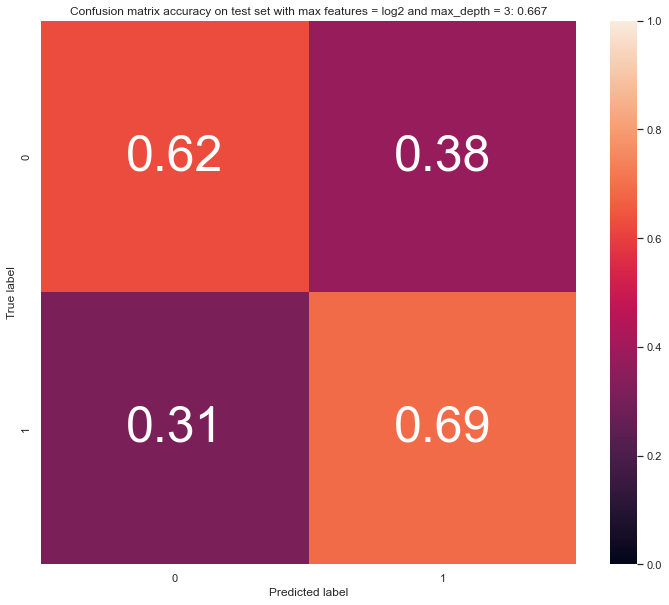

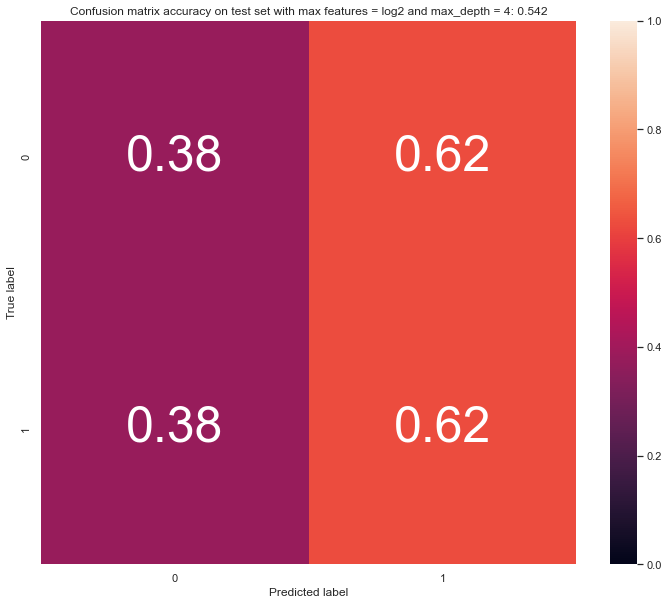

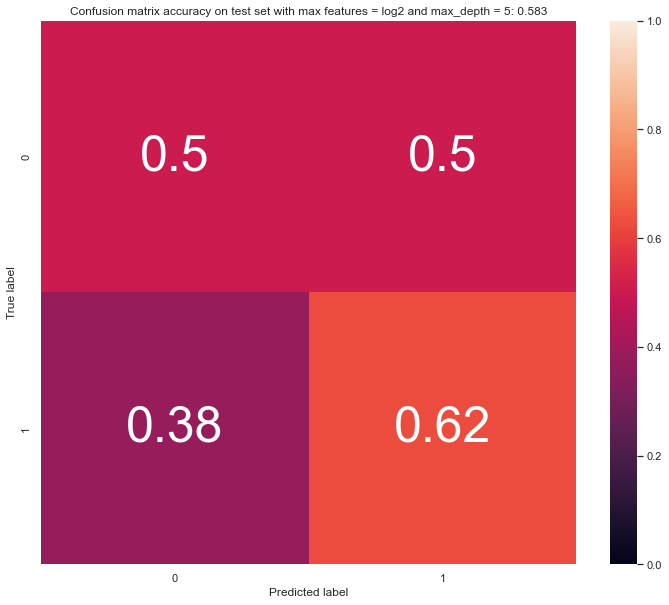

In [24]:
from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

In [25]:
df=pd.DataFrame(data=images_sift_glcm)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with max features = 1 and max_depth = None: 0.583
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.458
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.500
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.542
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.583
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.583
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.583
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.542
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.583
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.583
Classification accuracy on test set with max features = log2 and max_depth = None: 0.625
Classification accuracy on test set with max features = log2

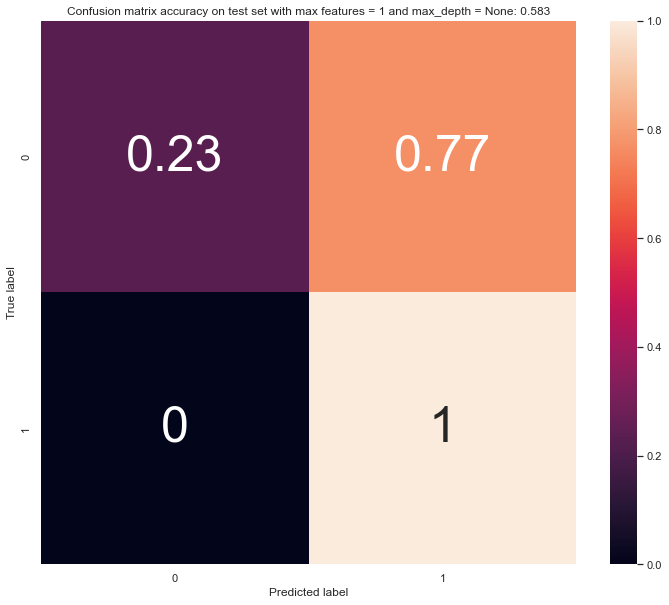

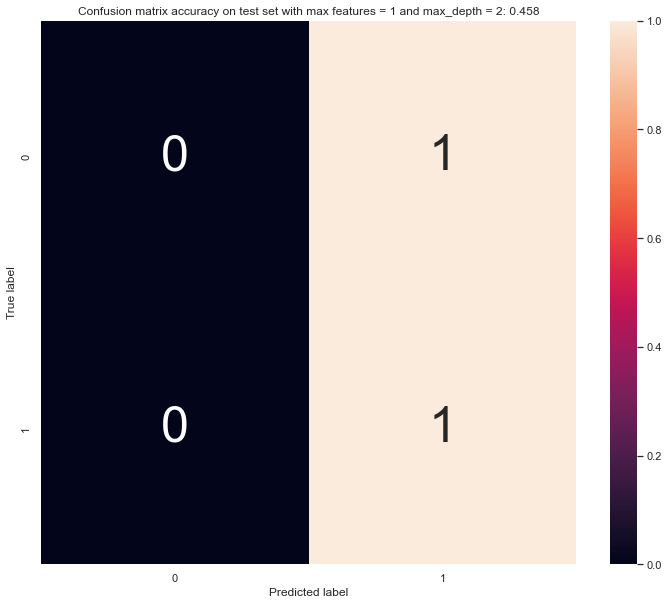

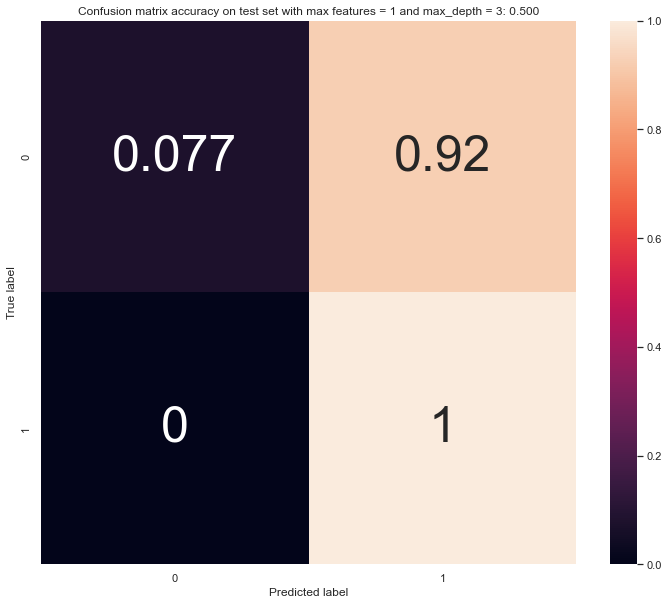

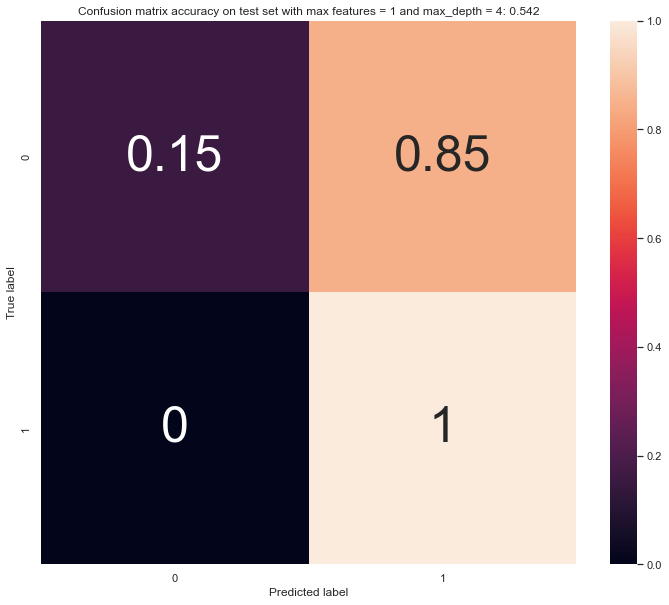

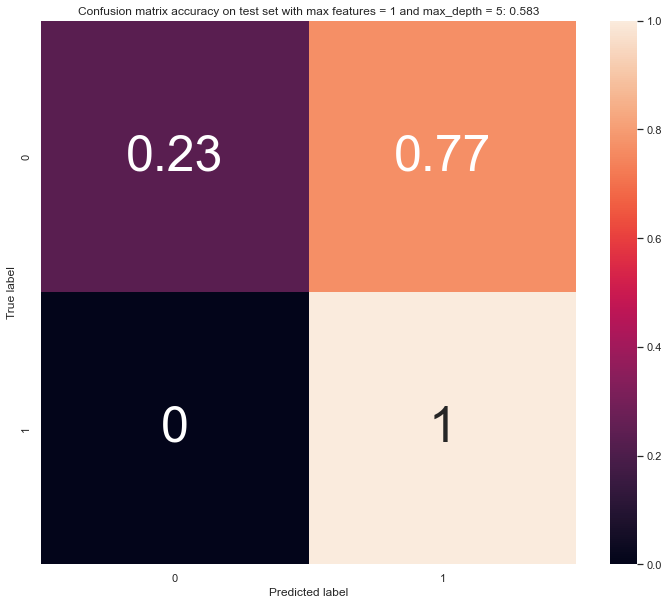

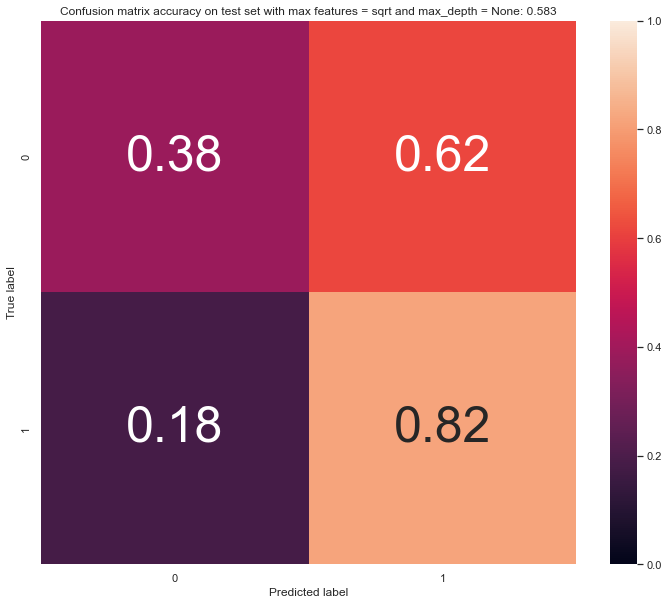

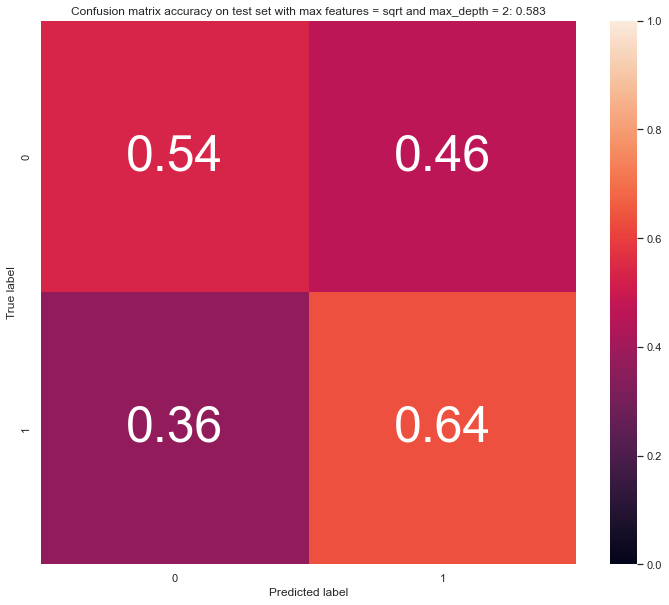

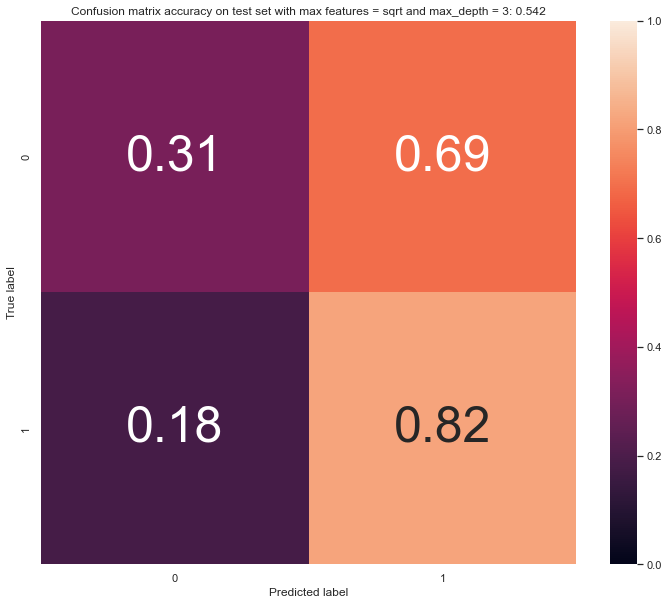

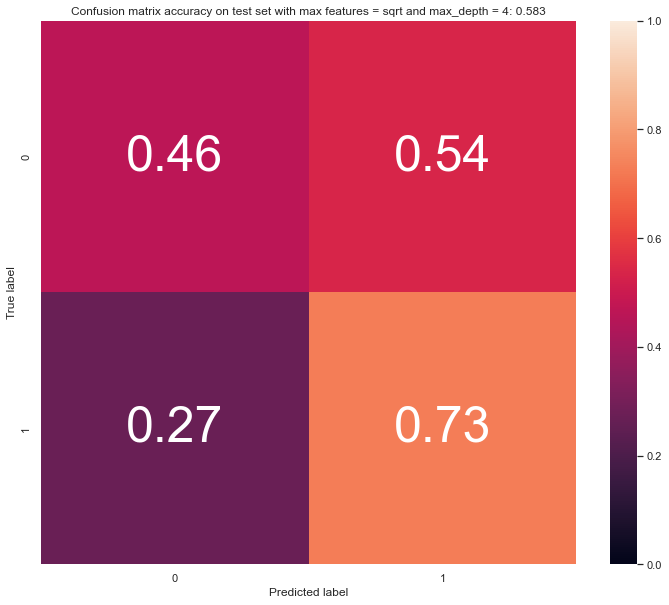

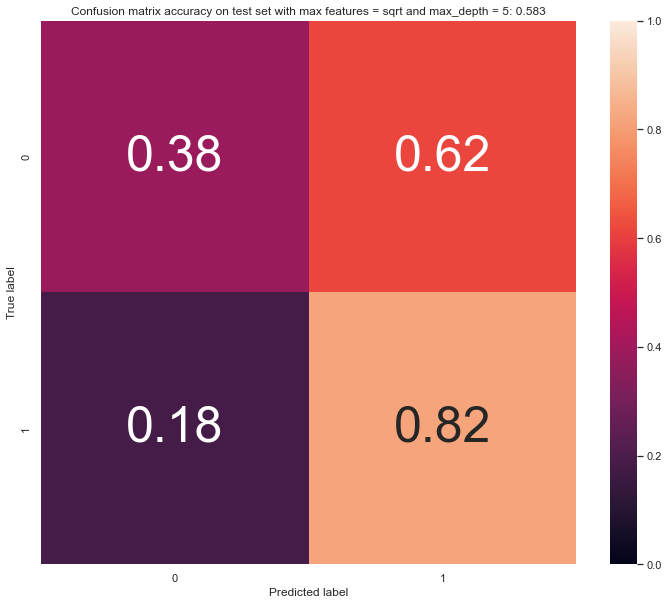

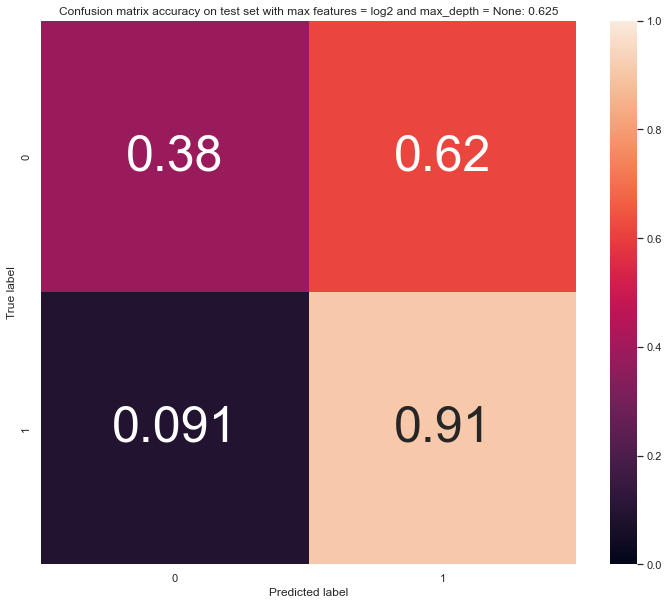

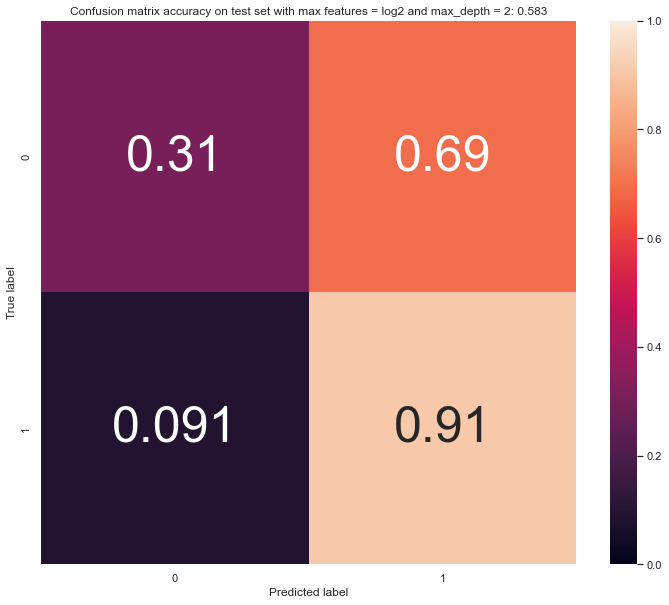

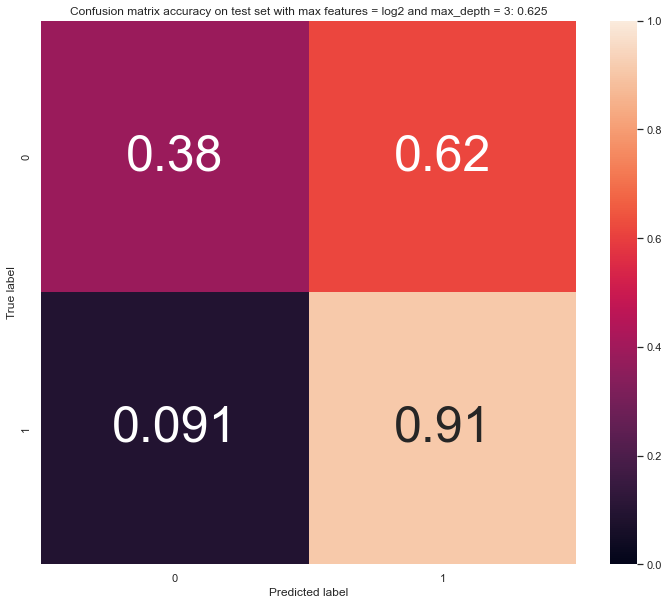

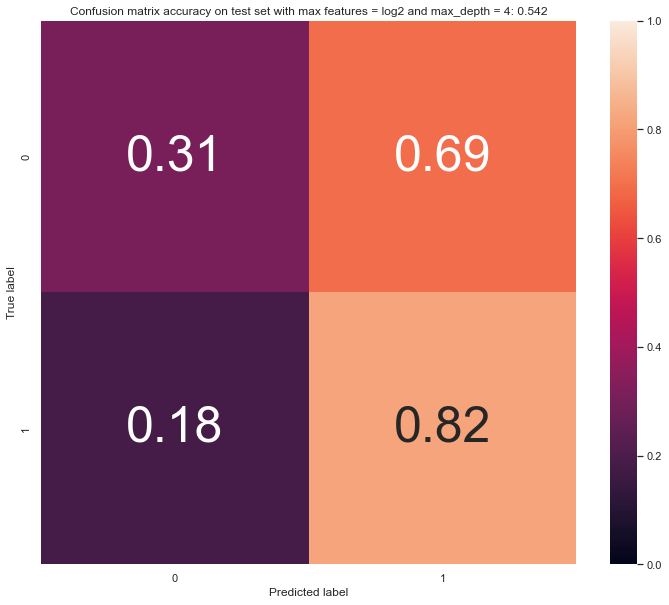

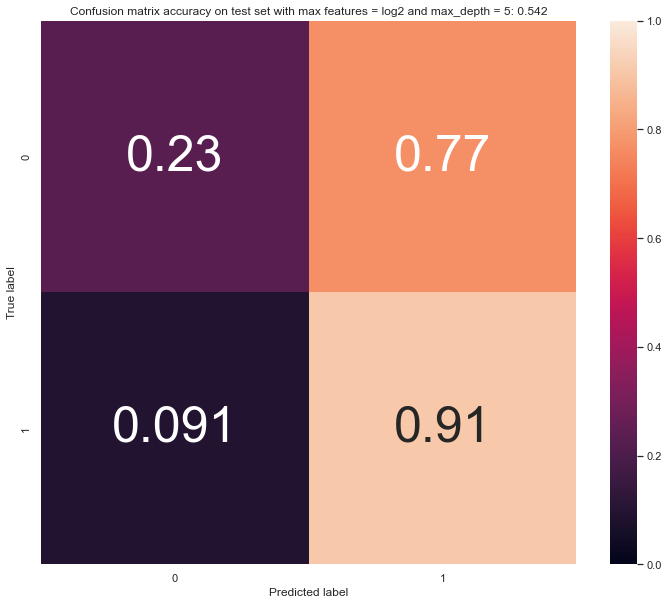

In [26]:
from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

# SVM

In [27]:
df=pd.DataFrame(data=images_sift)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with kernel = linear and gamma = 0.1: 0.833
Classification accuracy on test set with kernel = linear and gamma = 0.01: 0.833
Classification accuracy on test set with kernel = linear and gamma = 0.001: 0.833
Classification accuracy on test set with kernel = linear and gamma = 0.0001: 0.833
Classification accuracy on test set with kernel = linear and gamma = 0.11: 0.833
Classification accuracy on test set with kernel = poly and gamma = 0.1: 0.792
Classification accuracy on test set with kernel = poly and gamma = 0.01: 0.792
Classification accuracy on test set with kernel = poly and gamma = 0.001: 0.792
Classification accuracy on test set with kernel = poly and gamma = 0.0001: 0.792
Classification accuracy on test set with kernel = poly and gamma = 0.11: 0.792
Classification accuracy on test set with kernel = rbf and gamma = 0.1: 0.542
Classification accuracy on test set with kernel = rbf and gamma = 0.01: 0.542
Classification accuracy on test set with 

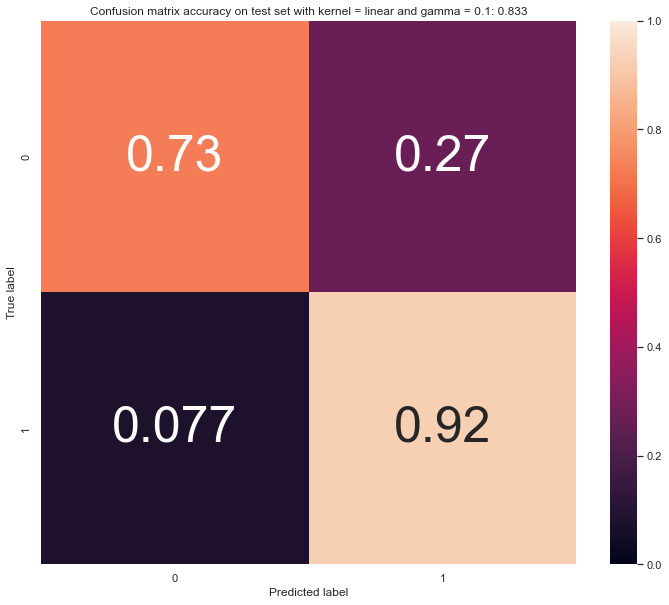

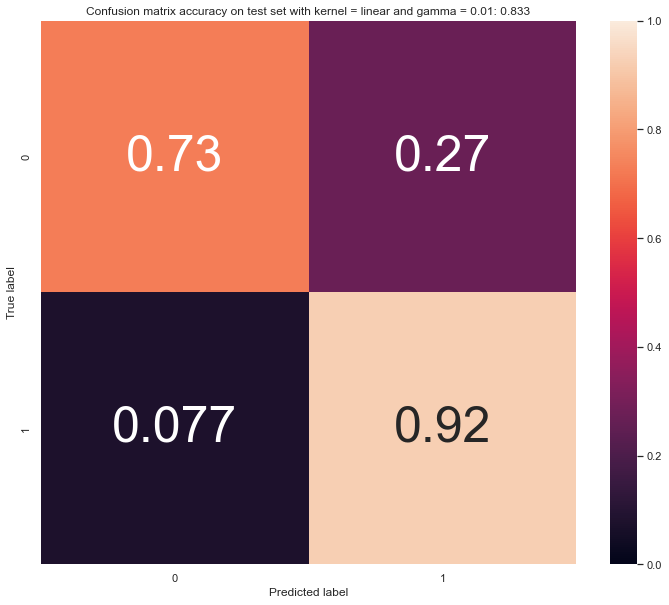

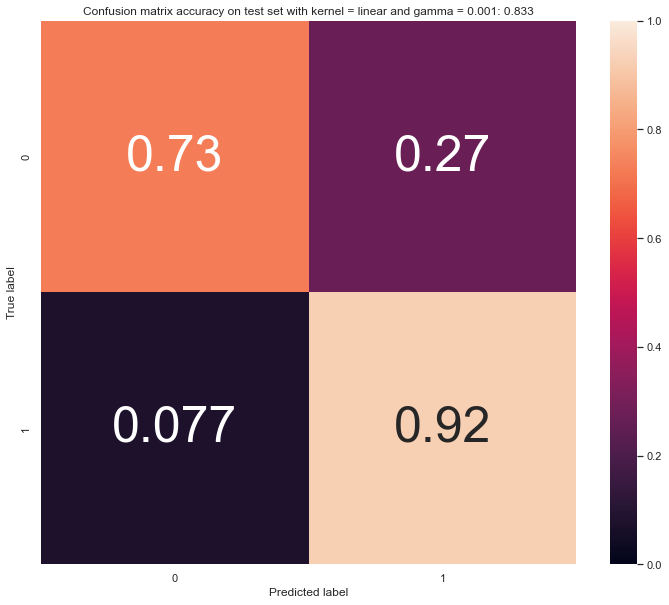

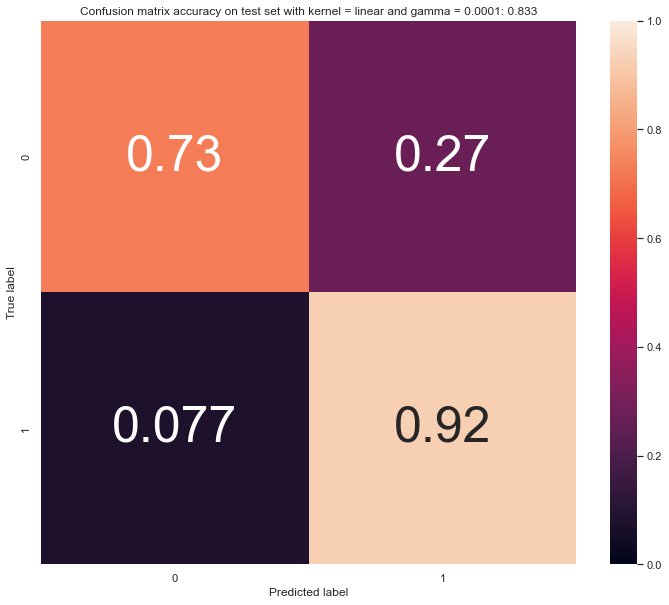

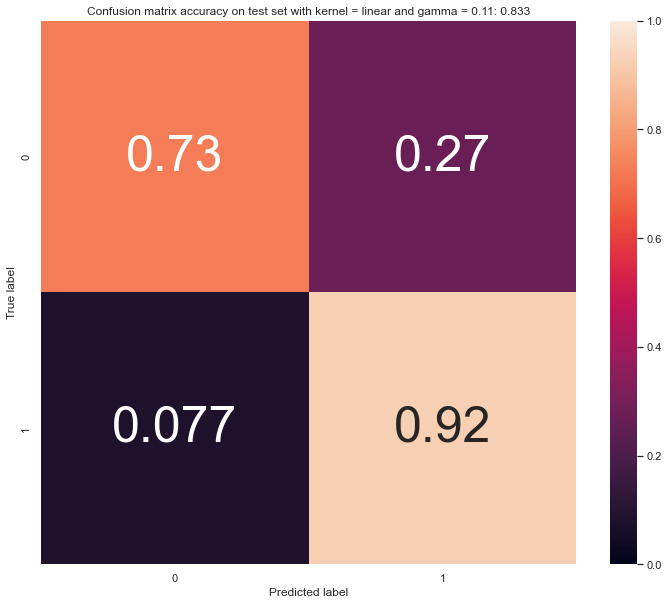

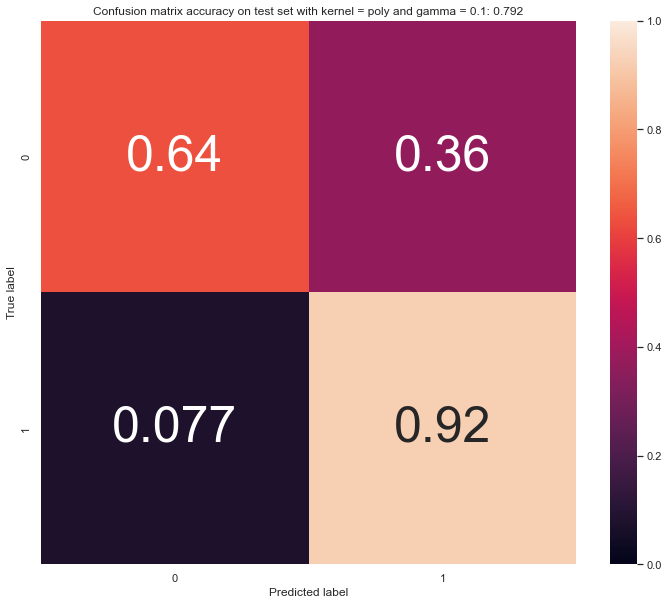

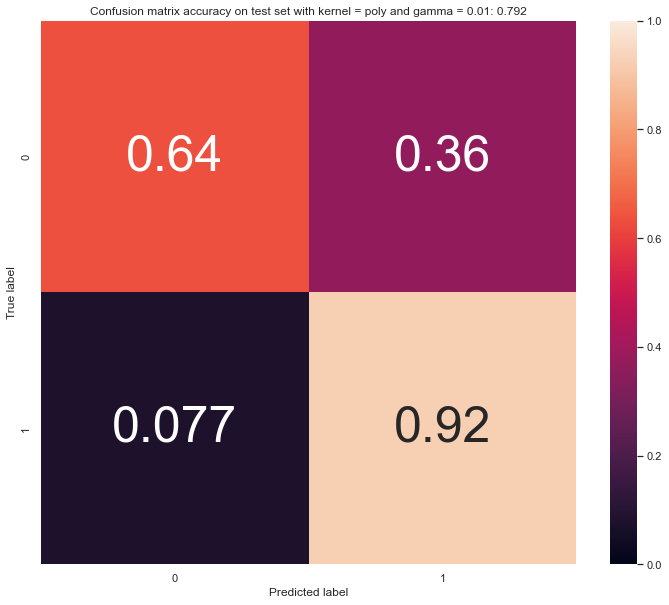

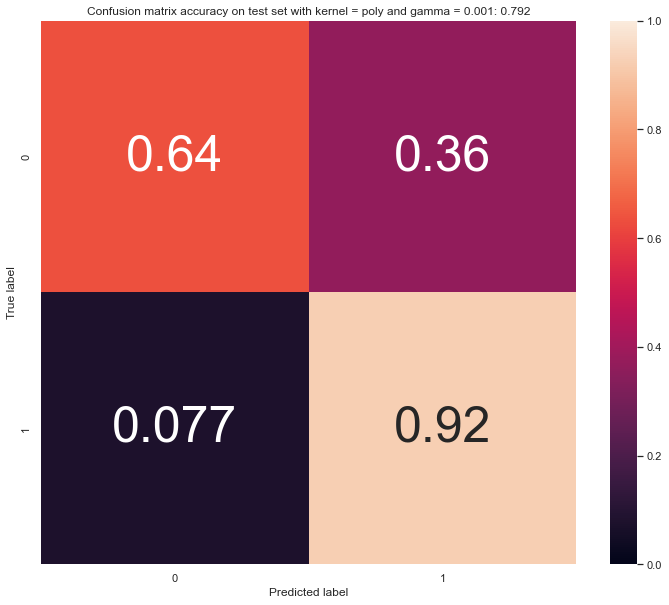

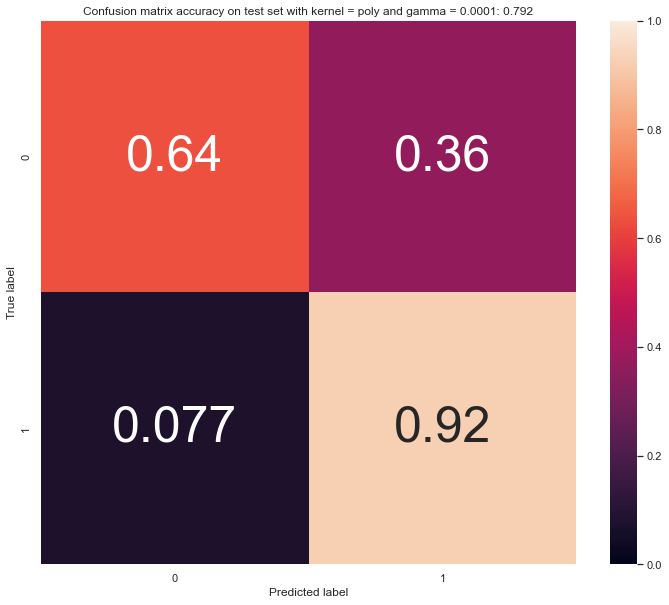

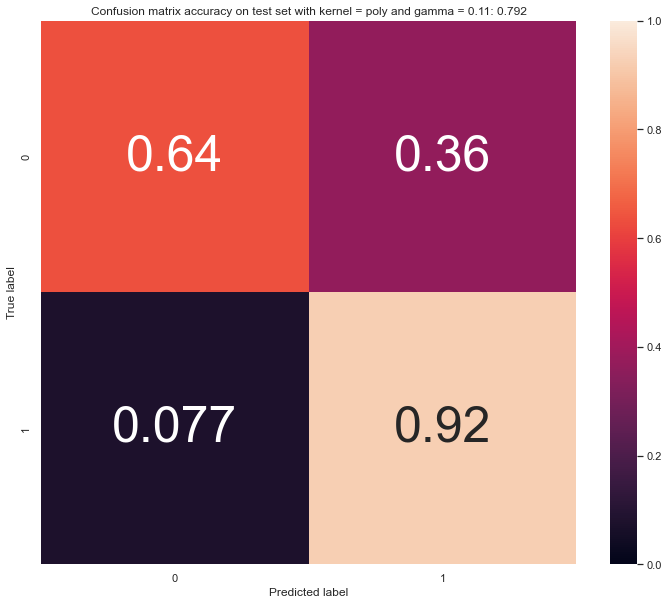

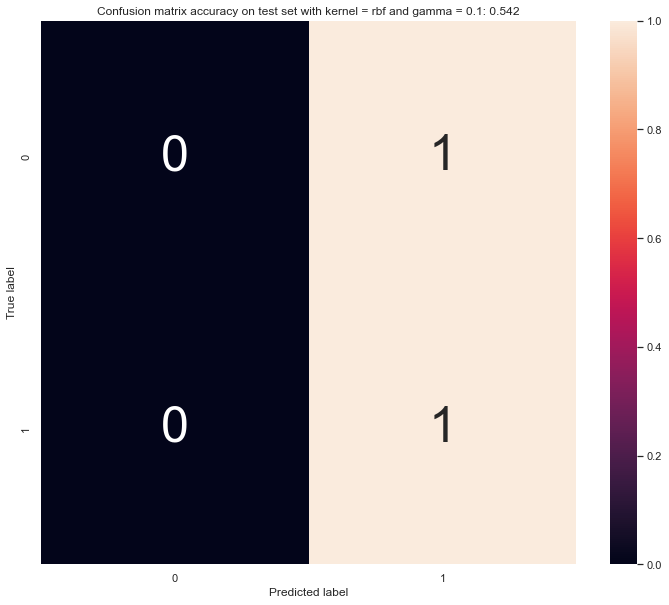

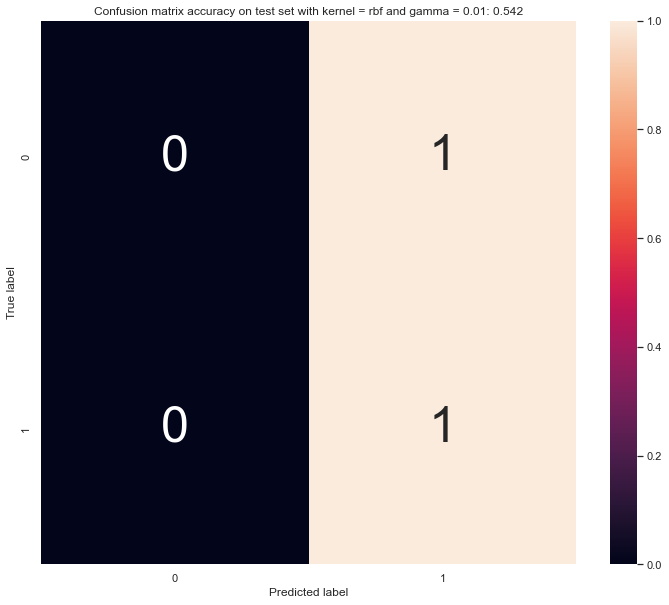

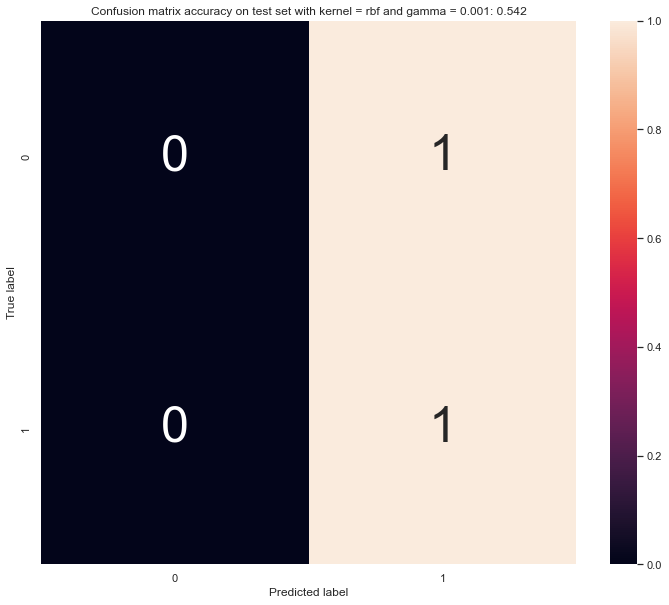

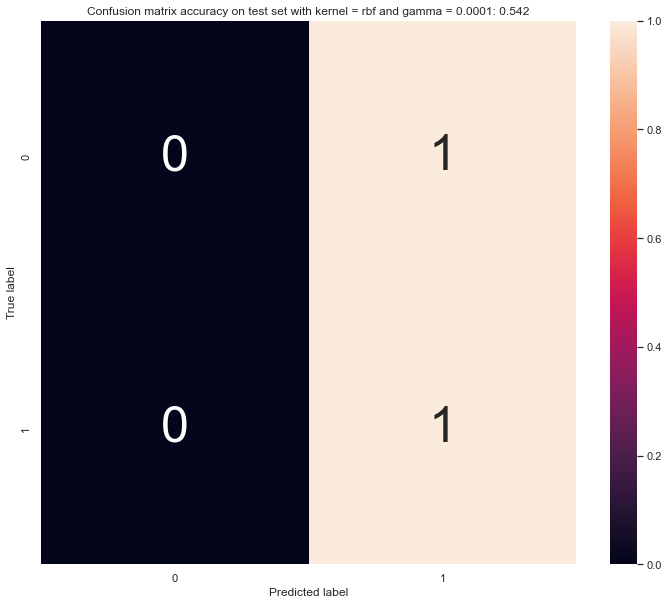

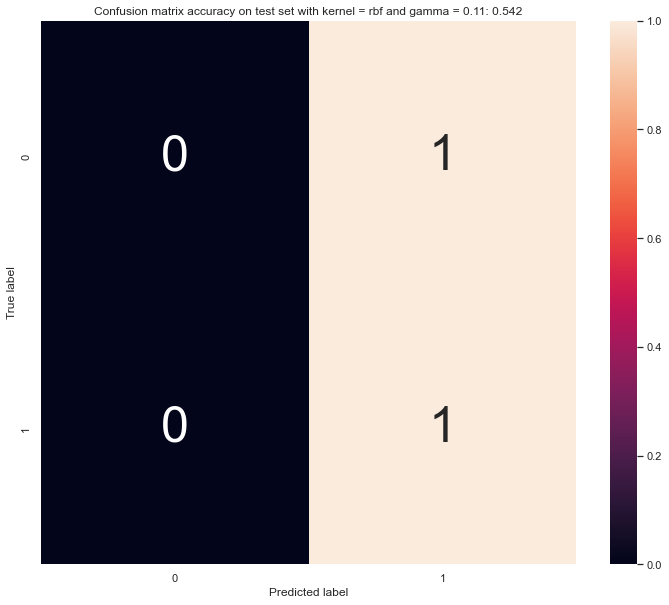

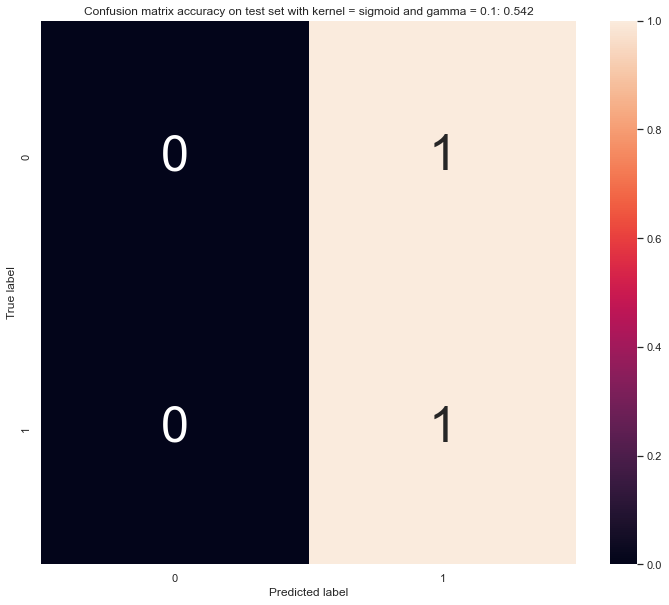

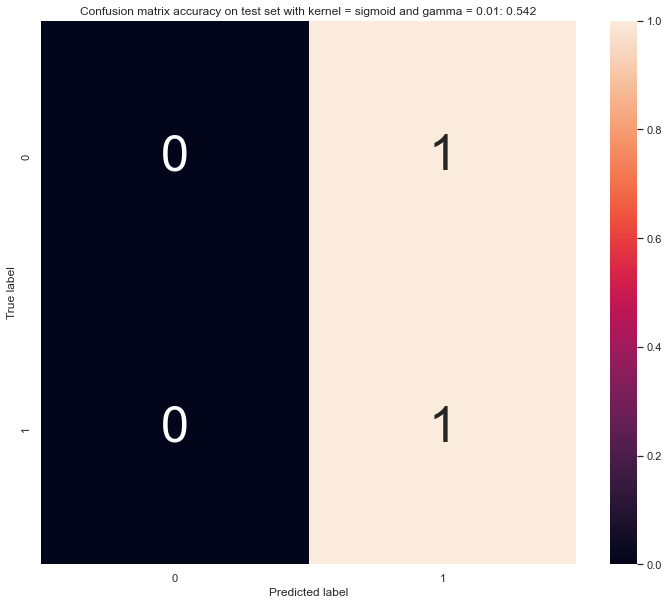

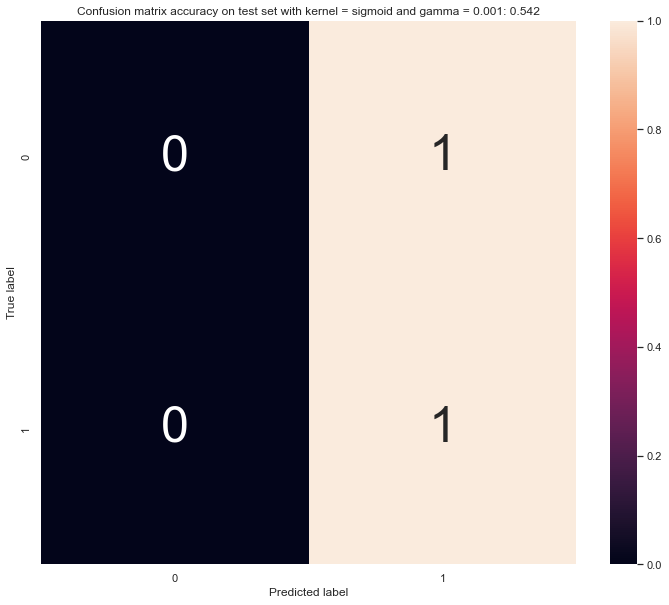

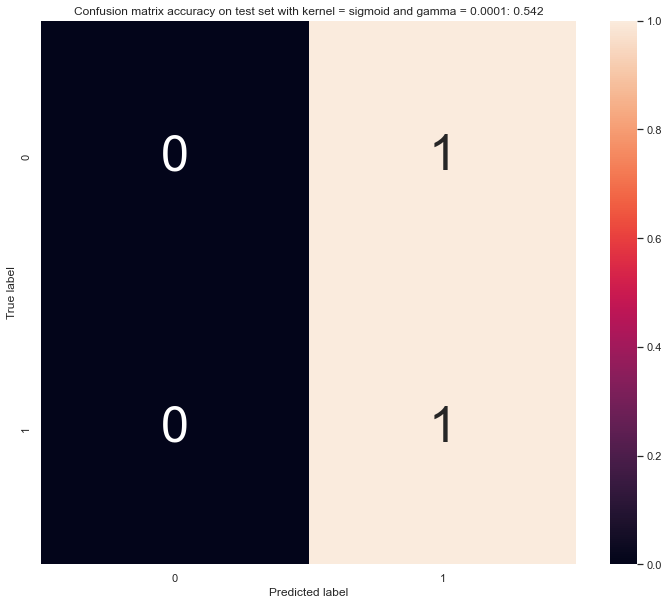

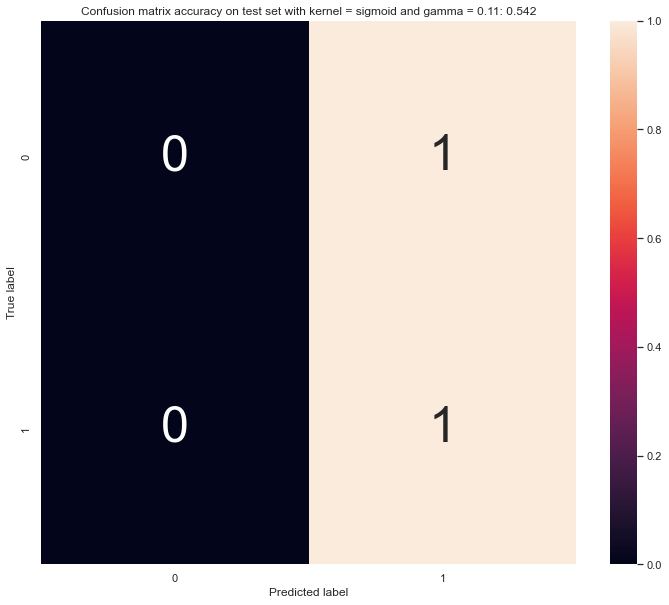

In [28]:
from itertools import product
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = [0.1,0.01,0.001,0.00010,0.11]
for k,g in product(kernel,gamma): # with product we can iterate through all possible combinations
    svM = svm.SVC(kernel=k,
                  gamma=g)
    svM.fit(X_train, y_train)
    prediction_test = svM.predict(X=X_test)
    print('Classification accuracy on test set with kernel = {} and gamma = {}: {:.3f}'.format(k, g, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with kernel = {} and gamma = {}: {:.3f}'.format(k, g, accuracy_score(y_test,prediction_test)))

In [29]:
df=pd.DataFrame(data=glcm)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with kernel = linear and gamma = 0.1: 0.583
Classification accuracy on test set with kernel = linear and gamma = 0.01: 0.583
Classification accuracy on test set with kernel = linear and gamma = 0.001: 0.583
Classification accuracy on test set with kernel = linear and gamma = 0.0001: 0.583
Classification accuracy on test set with kernel = linear and gamma = 0.11: 0.583
Classification accuracy on test set with kernel = poly and gamma = 0.1: 0.500
Classification accuracy on test set with kernel = poly and gamma = 0.01: 0.542
Classification accuracy on test set with kernel = poly and gamma = 0.001: 0.625
Classification accuracy on test set with kernel = poly and gamma = 0.0001: 0.458
Classification accuracy on test set with kernel = poly and gamma = 0.11: 0.500
Classification accuracy on test set with kernel = rbf and gamma = 0.1: 0.625
Classification accuracy on test set with kernel = rbf and gamma = 0.01: 0.500
Classification accuracy on test set with 

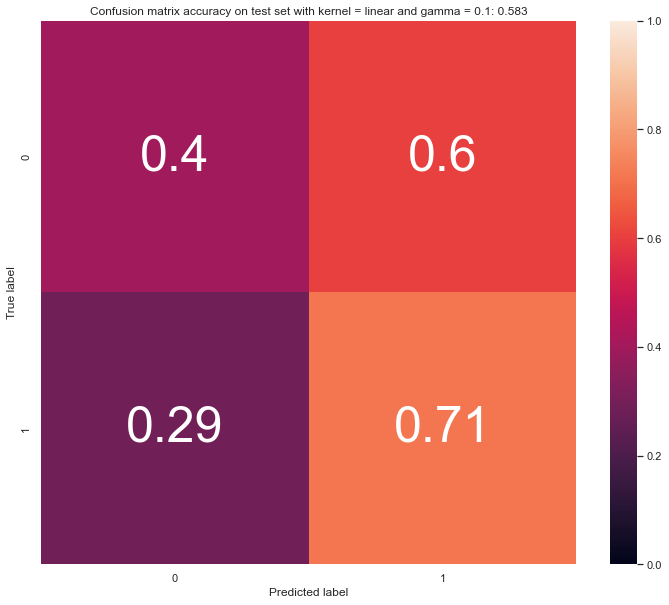

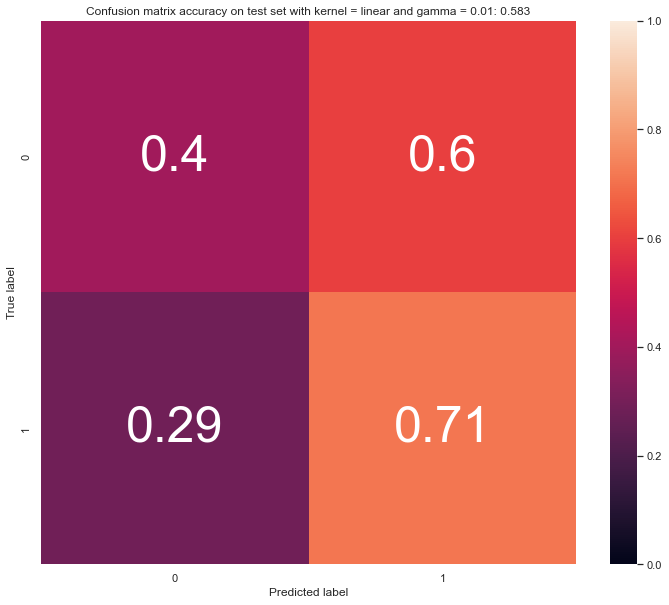

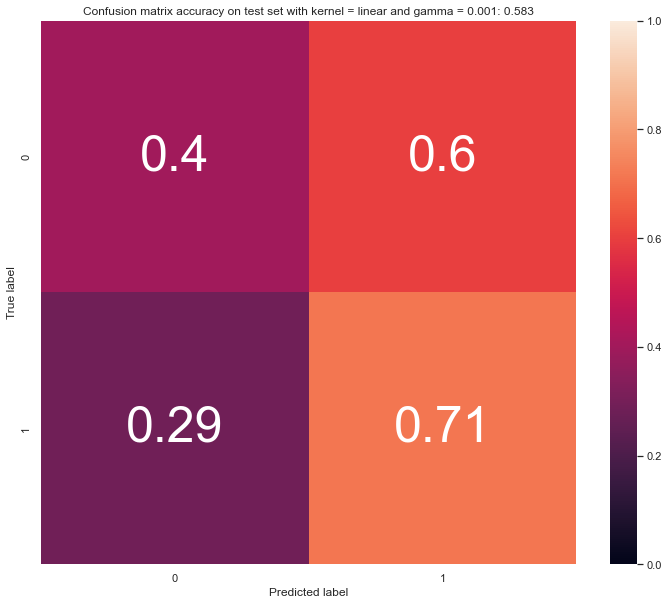

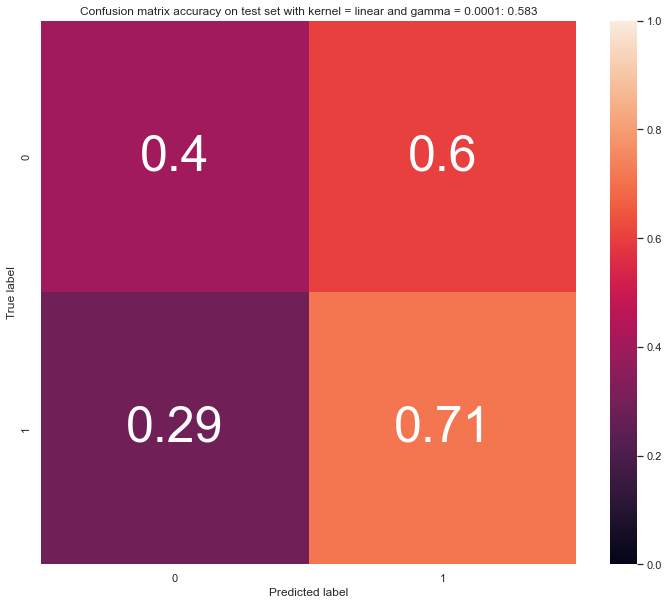

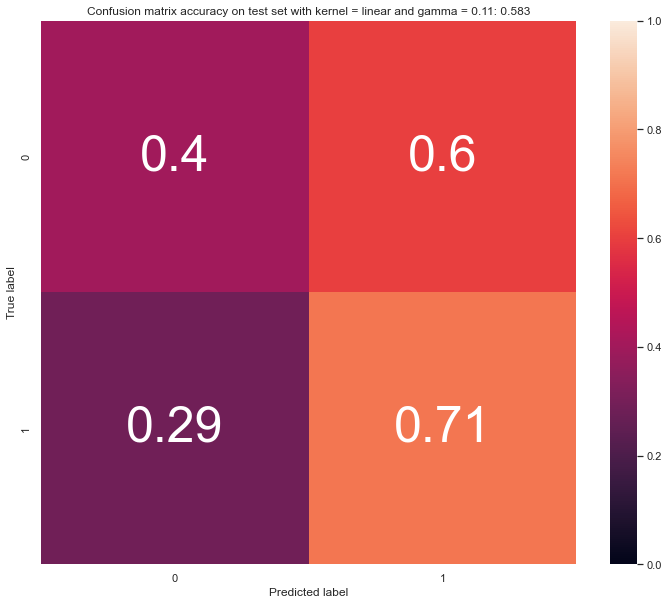

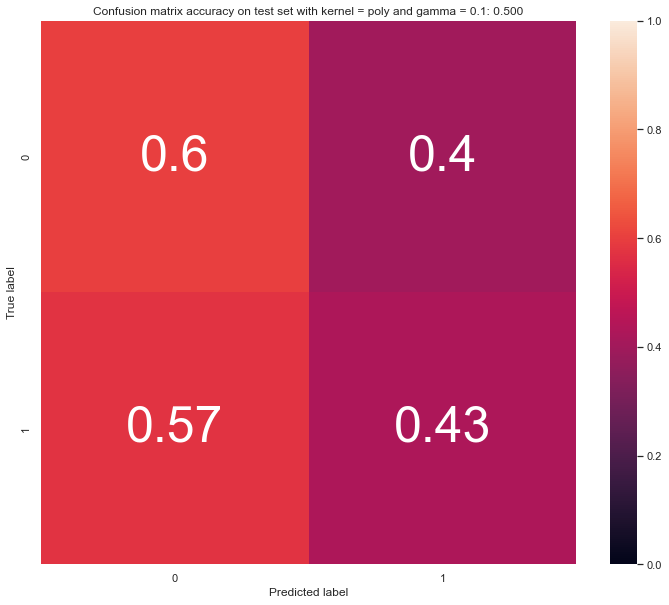

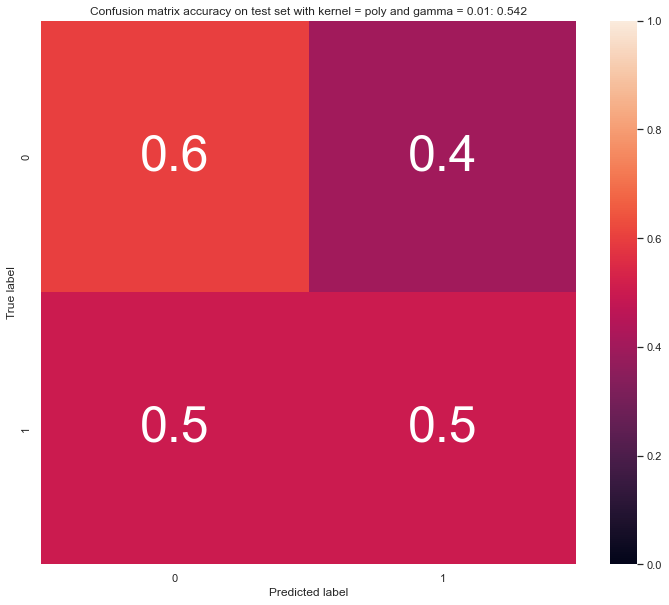

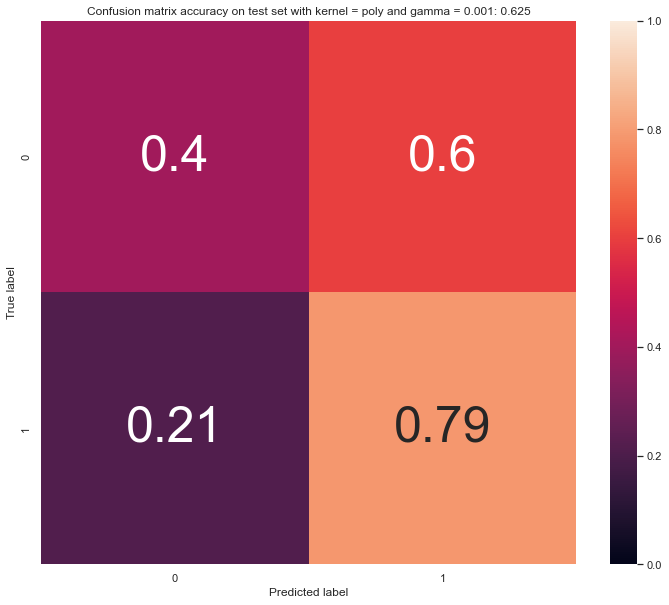

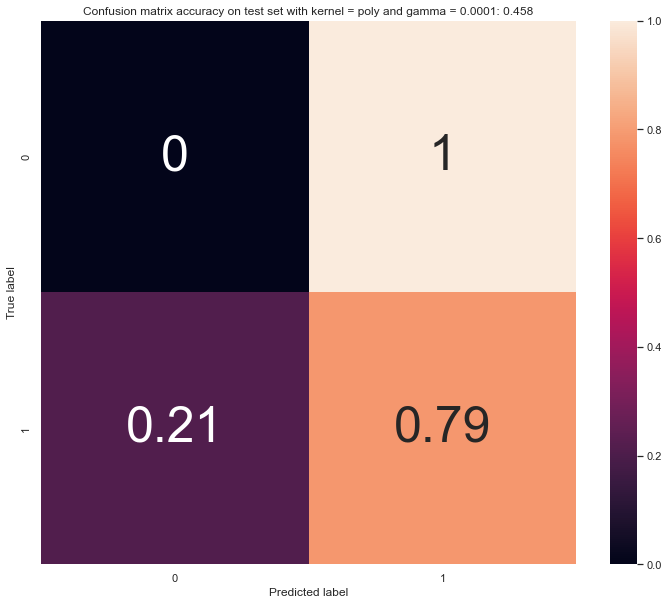

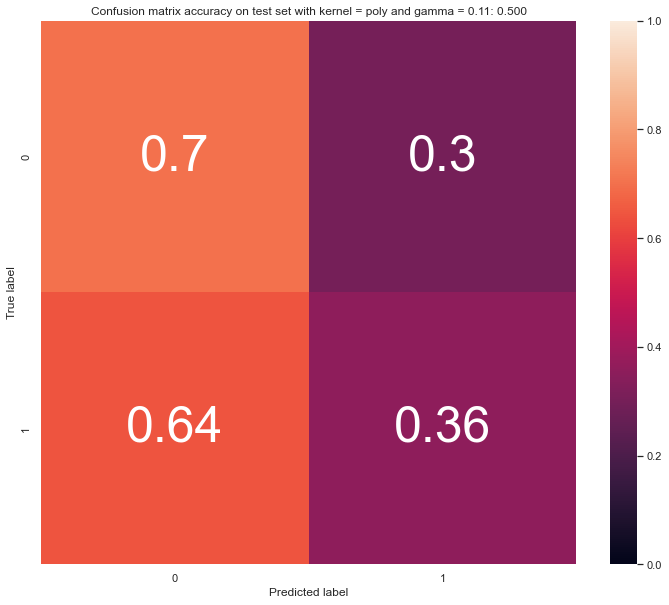

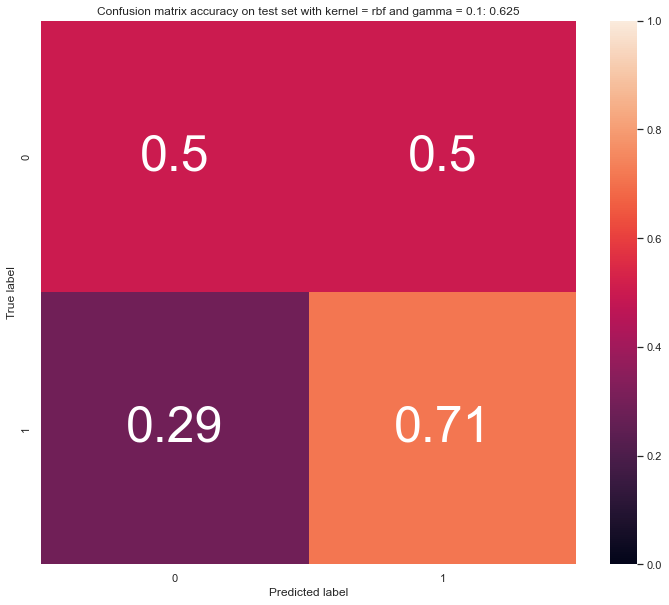

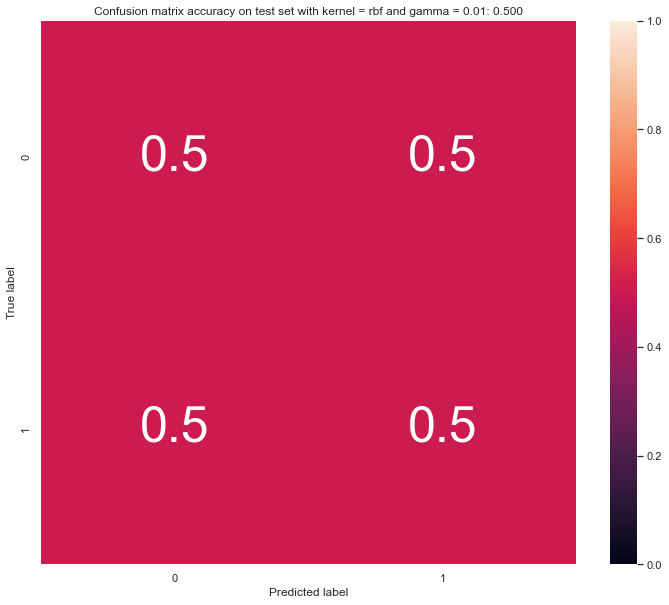

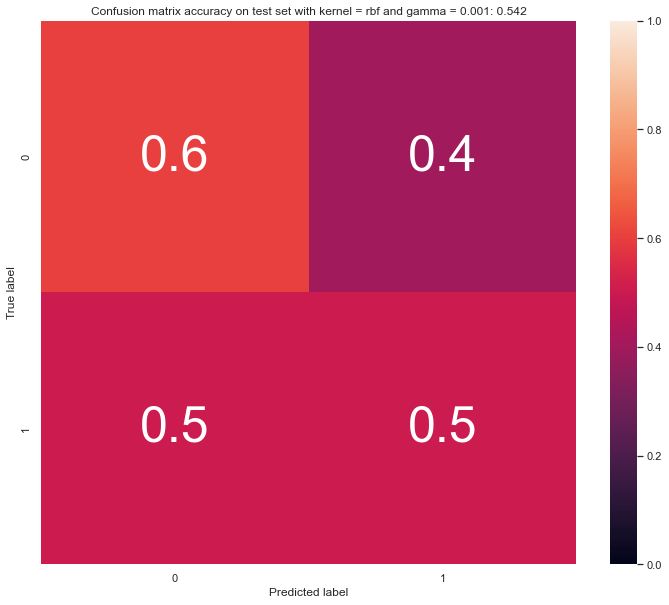

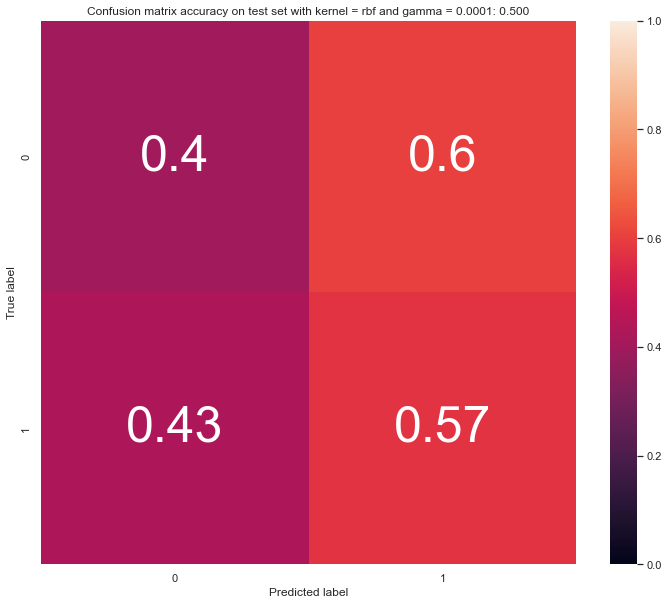

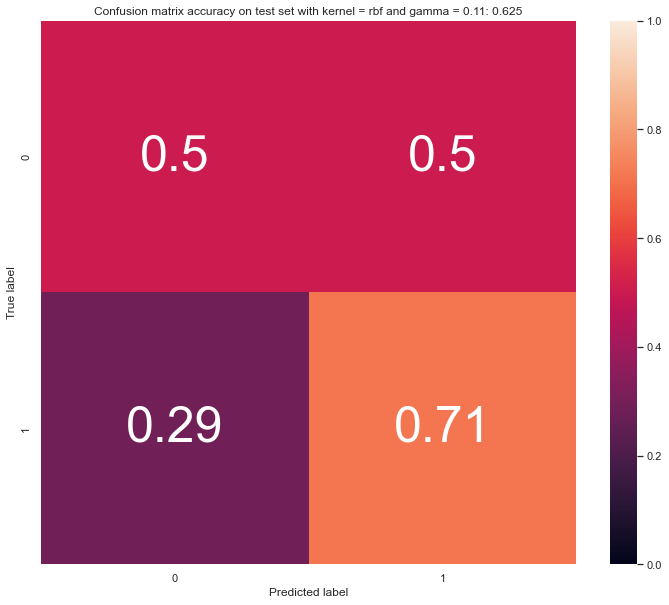

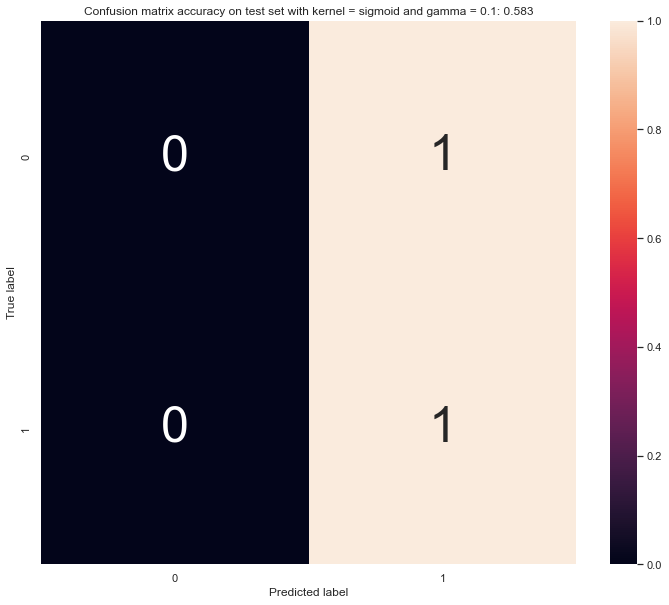

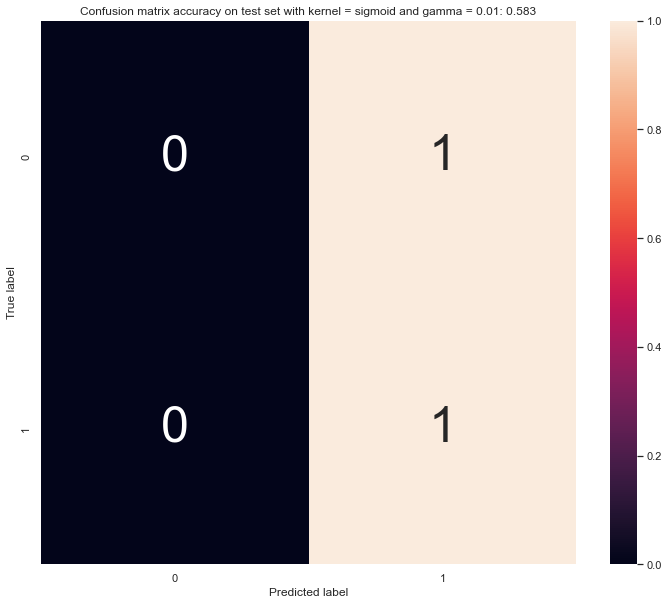

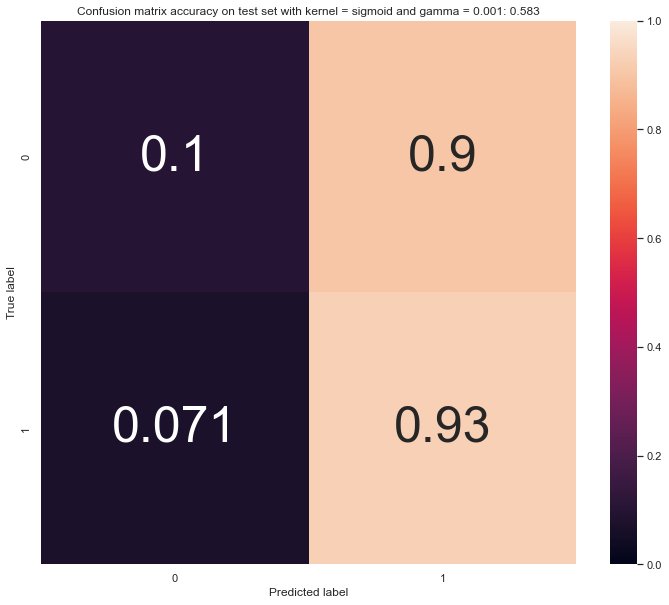

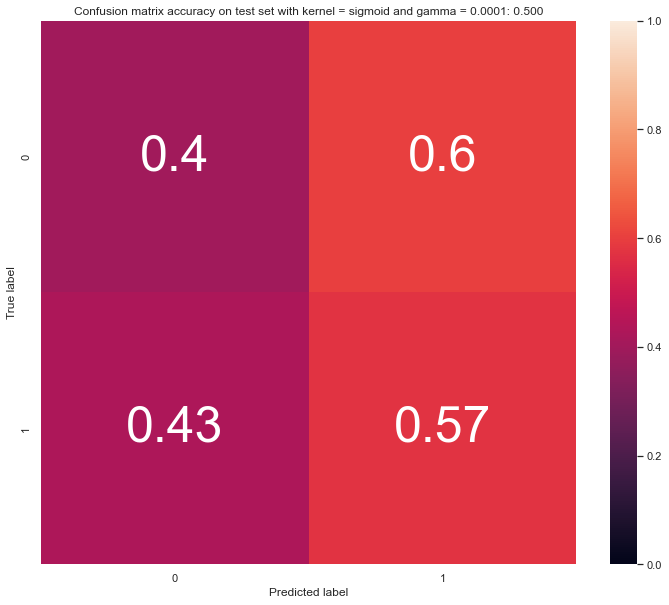

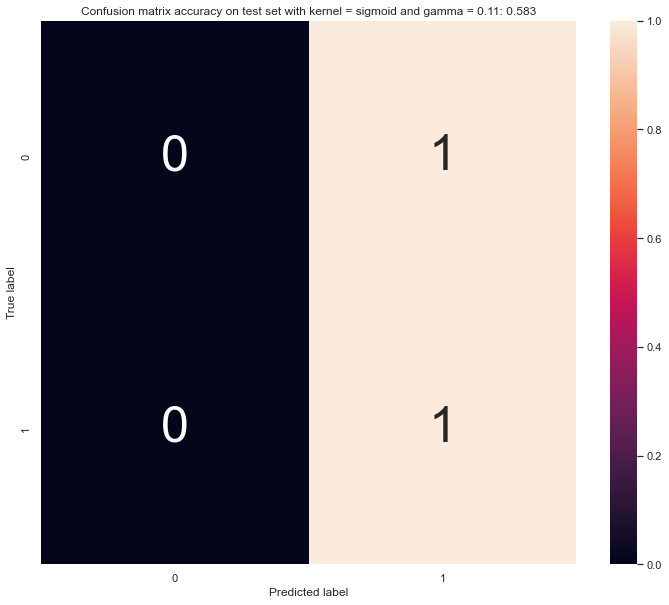

In [30]:
from itertools import product
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = [0.1,0.01,0.001,0.00010,0.11]
for k,g in product(kernel,gamma): # with product we can iterate through all possible combinations
    svM = svm.SVC(kernel=k,
                  gamma=g)
    svM.fit(X_train, y_train)
    prediction_test = svM.predict(X=X_test)
    print('Classification accuracy on test set with kernel = {} and gamma = {}: {:.3f}'.format(k, g, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with kernel = {} and gamma = {}: {:.3f}'.format(k, g, accuracy_score(y_test,prediction_test)))

In [31]:
df=pd.DataFrame(data=images_sift_glcm)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with kernel = linear and gamma = 0.1: 0.750
Classification accuracy on test set with kernel = linear and gamma = 0.01: 0.750
Classification accuracy on test set with kernel = linear and gamma = 0.001: 0.750
Classification accuracy on test set with kernel = linear and gamma = 0.0001: 0.750
Classification accuracy on test set with kernel = linear and gamma = 0.11: 0.750
Classification accuracy on test set with kernel = poly and gamma = 0.1: 0.792
Classification accuracy on test set with kernel = poly and gamma = 0.01: 0.792
Classification accuracy on test set with kernel = poly and gamma = 0.001: 0.792
Classification accuracy on test set with kernel = poly and gamma = 0.0001: 0.792
Classification accuracy on test set with kernel = poly and gamma = 0.11: 0.792
Classification accuracy on test set with kernel = rbf and gamma = 0.1: 0.500
Classification accuracy on test set with kernel = rbf and gamma = 0.01: 0.500
Classification accuracy on test set with 

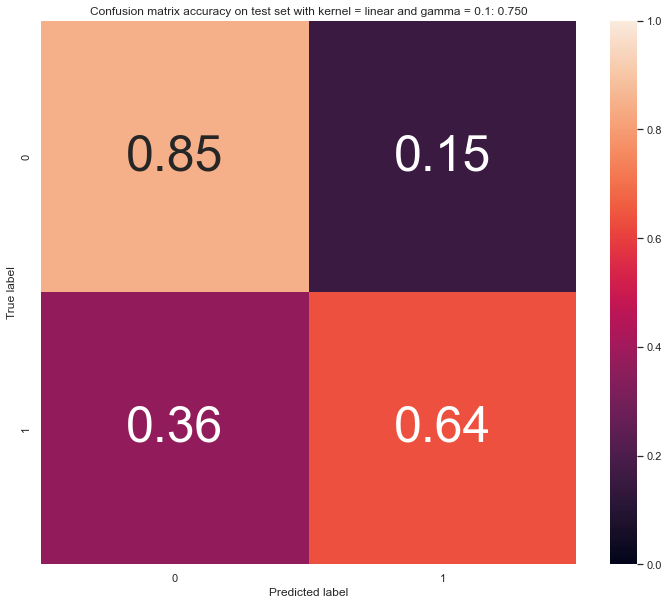

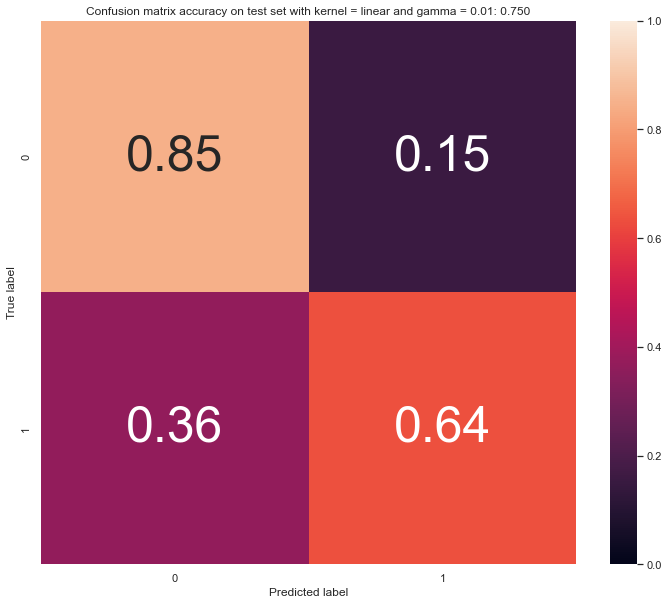

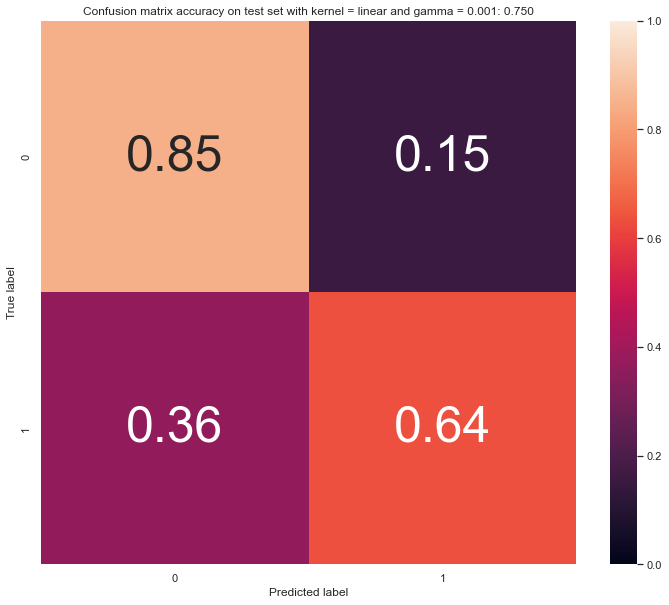

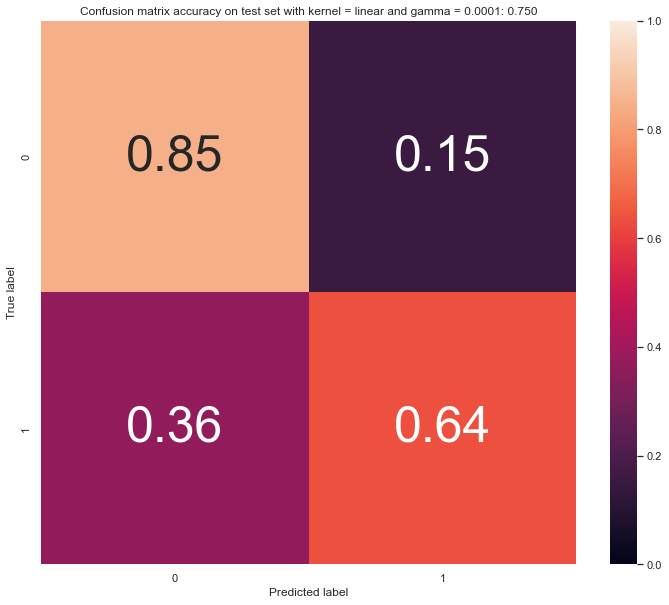

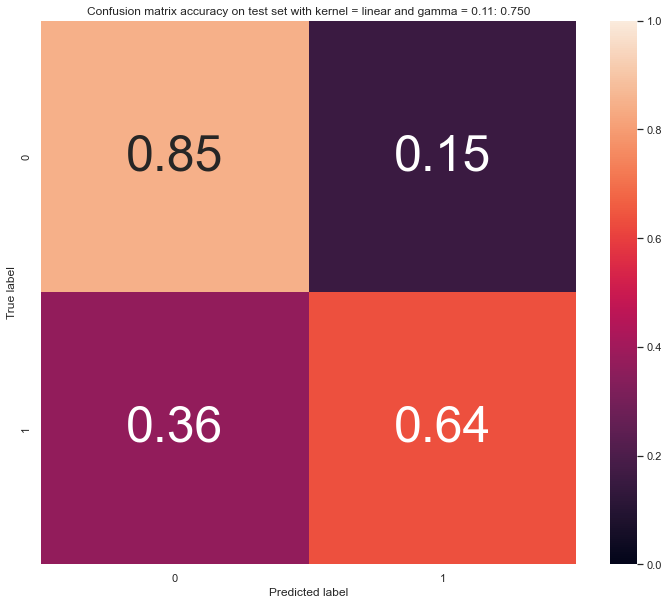

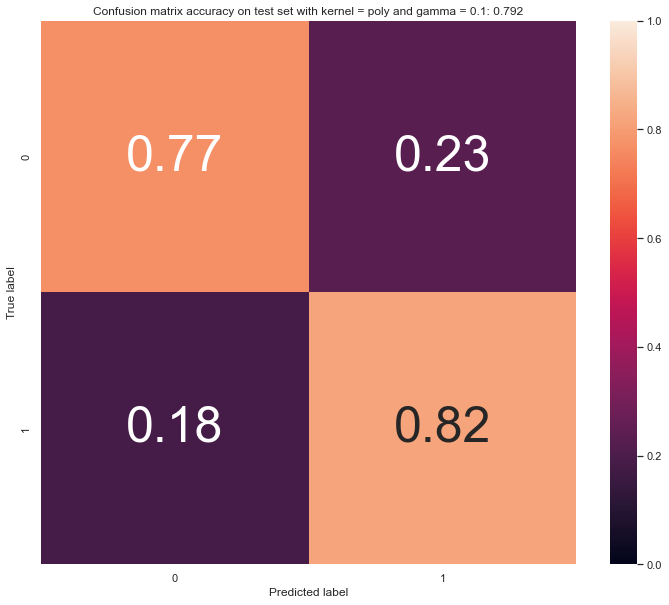

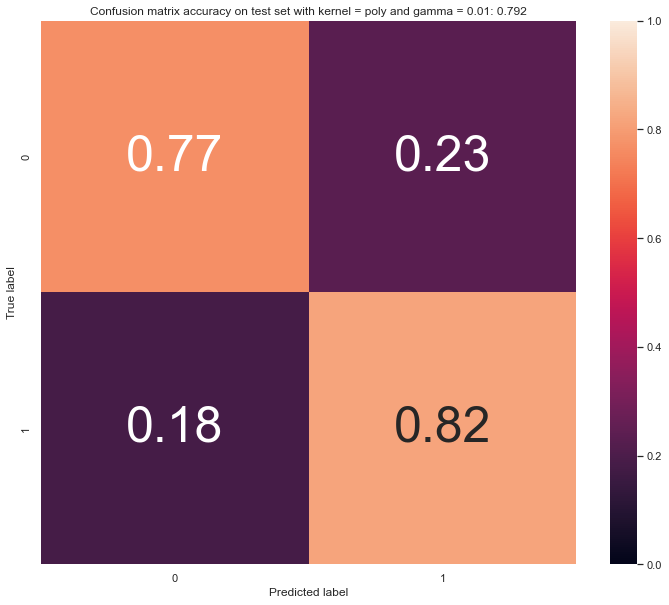

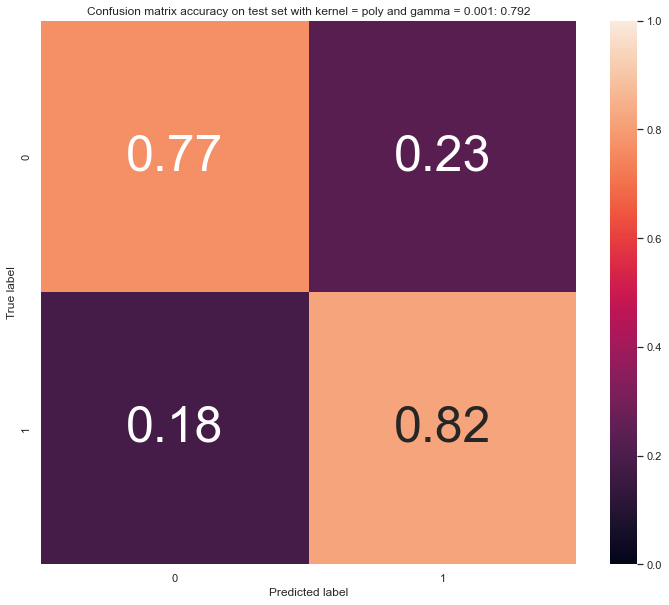

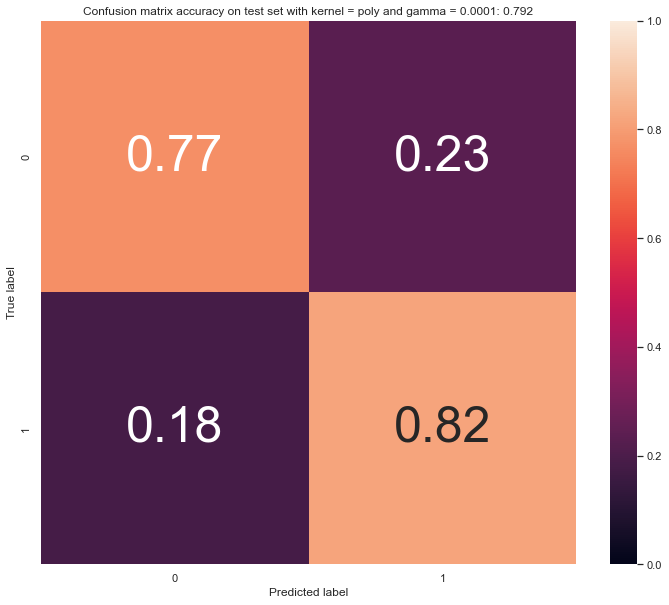

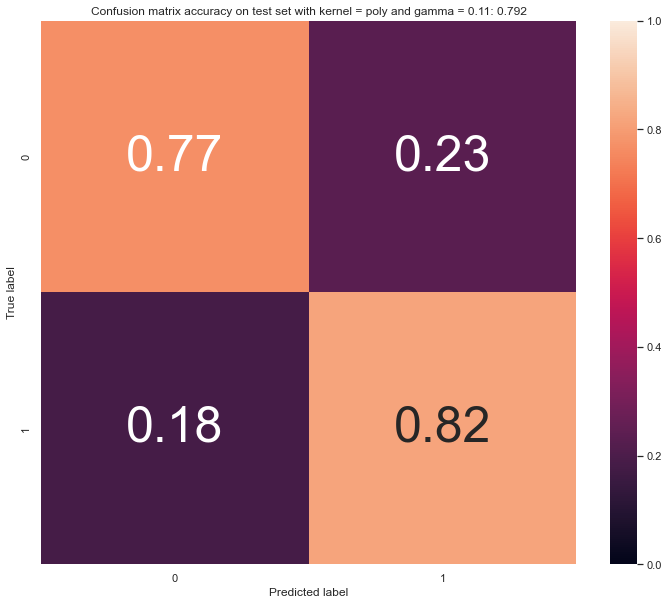

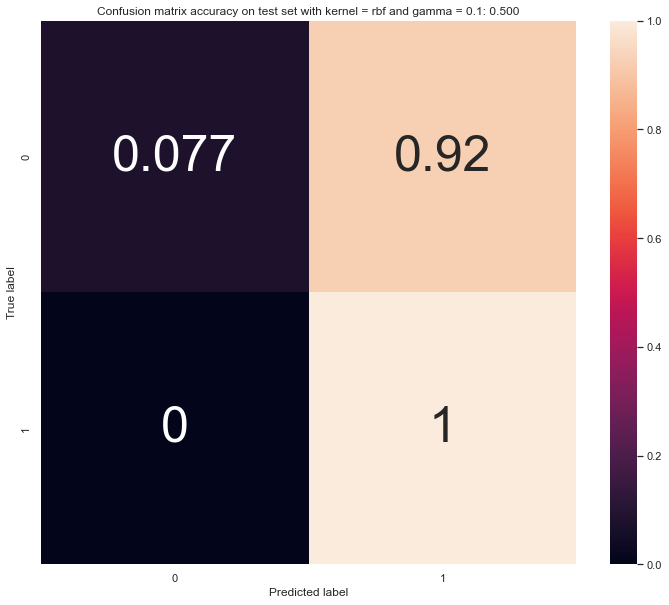

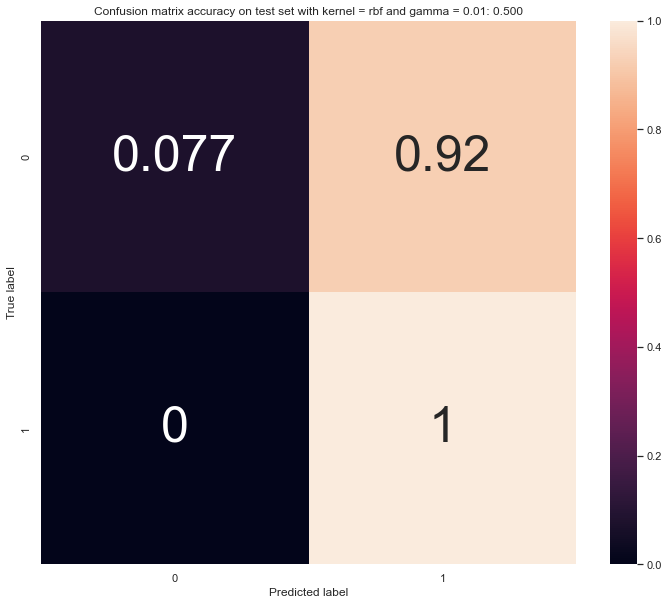

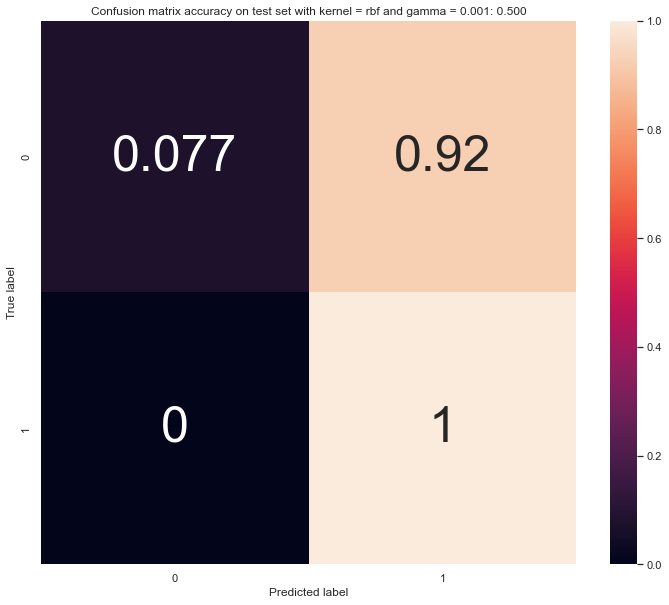

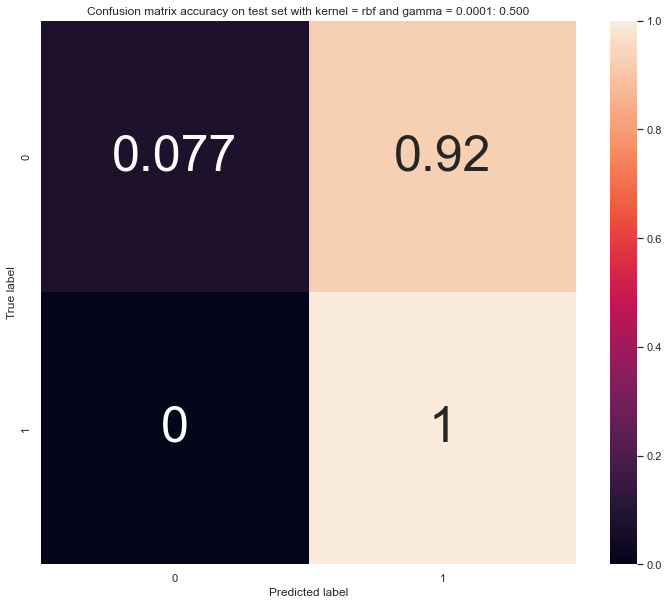

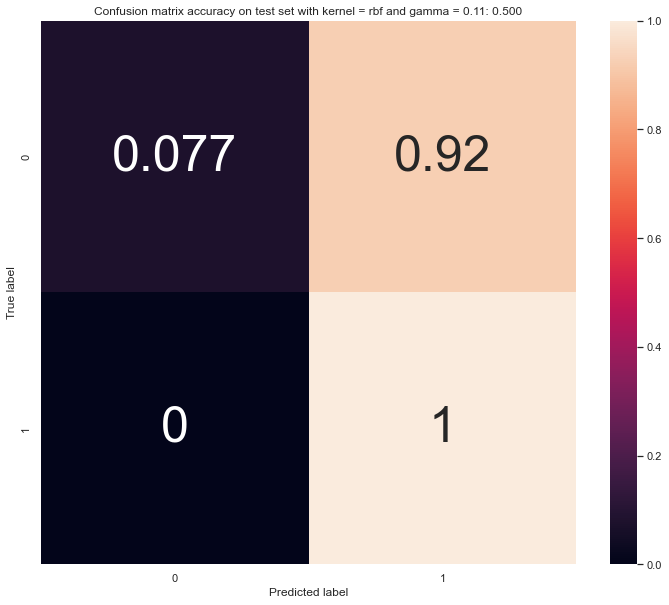

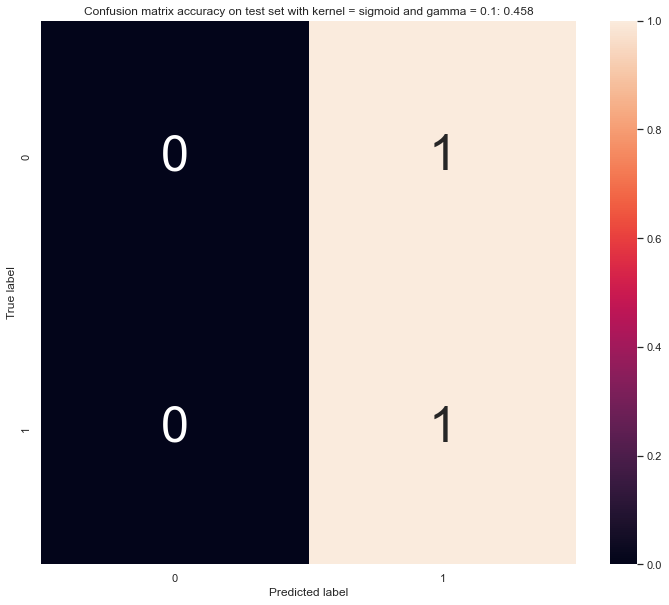

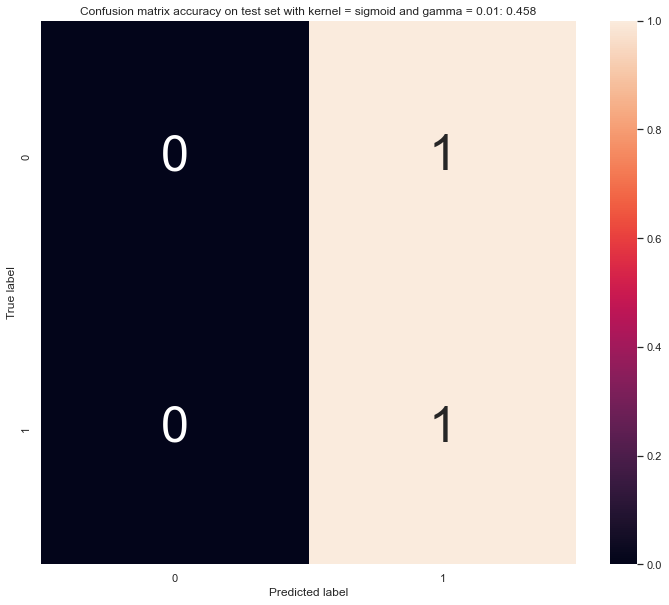

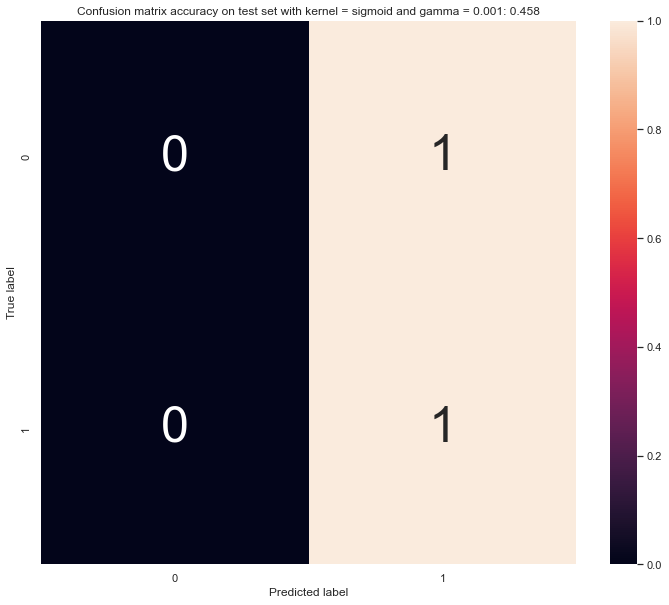

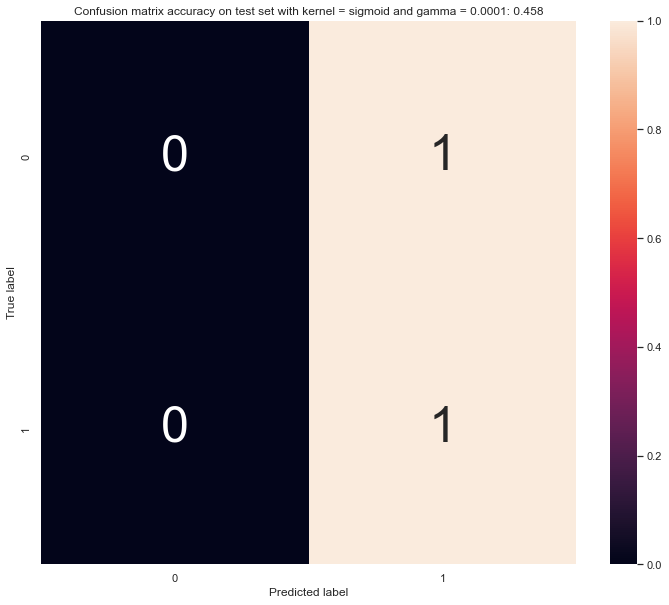

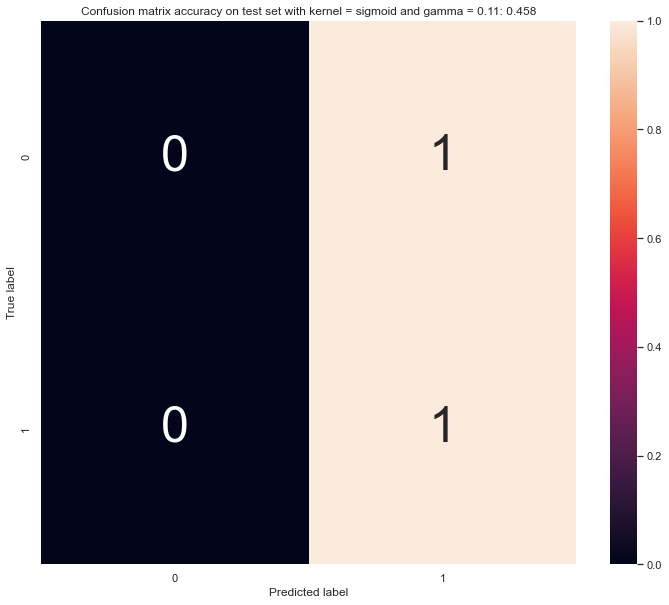

In [32]:
from itertools import product
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = [0.1,0.01,0.001,0.00010,0.11]
for k,g in product(kernel,gamma): # with product we can iterate through all possible combinations
    svM = svm.SVC(kernel=k,
                  gamma=g)
    svM.fit(X_train, y_train)
    prediction_test = svM.predict(X=X_test)
    print('Classification accuracy on test set with kernel = {} and gamma = {}: {:.3f}'.format(k, g, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with kernel = {} and gamma = {}: {:.3f}'.format(k, g, accuracy_score(y_test,prediction_test)))

# KNN

In [33]:
df=pd.DataFrame(data=images_sift)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with n = 12: 0.875
Classification accuracy on test set with n = 3: 0.792
Classification accuracy on test set with n = 4: 0.792
Classification accuracy on test set with n = 5: 0.833
Classification accuracy on test set with n = 6: 0.833
Classification accuracy on test set with n = 7: 0.833
Classification accuracy on test set with n = 8: 0.875


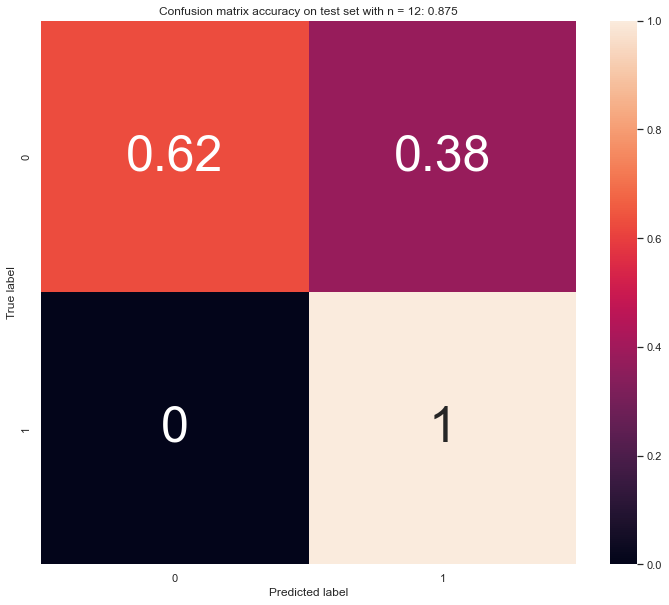

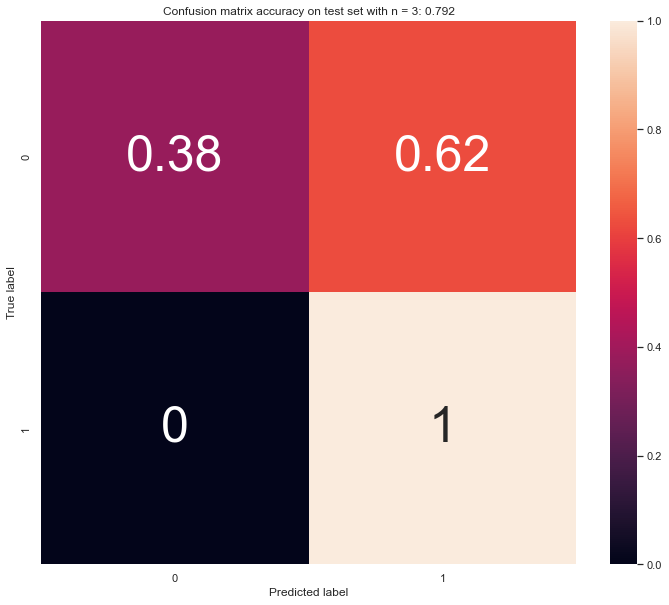

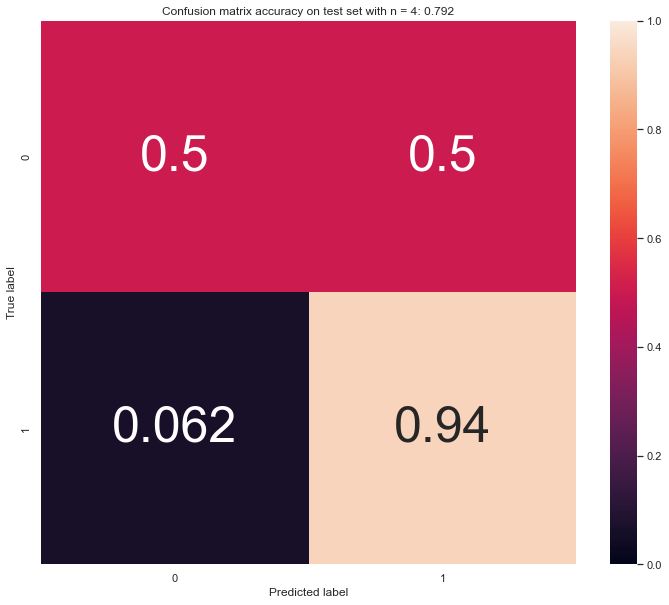

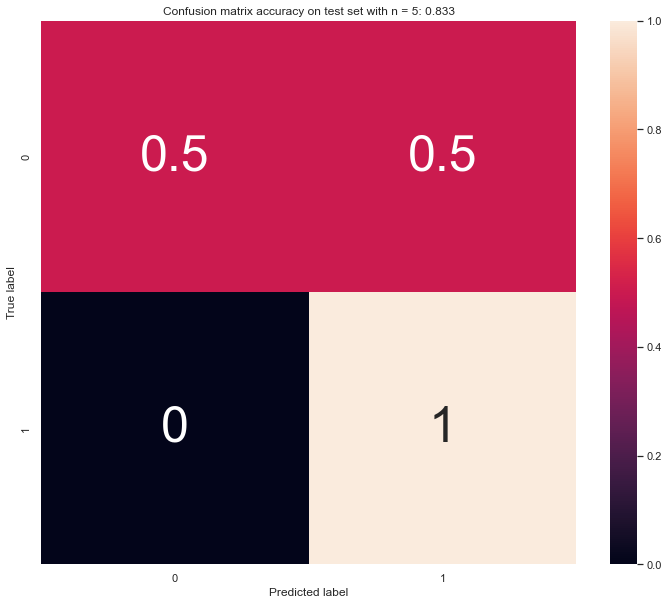

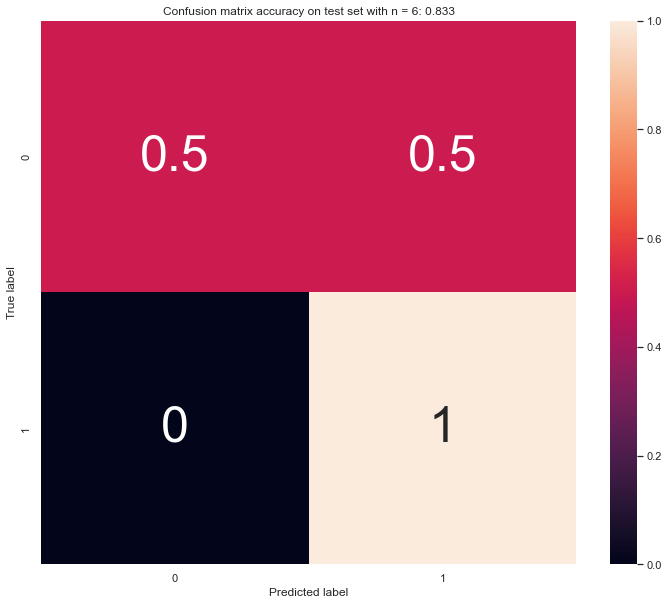

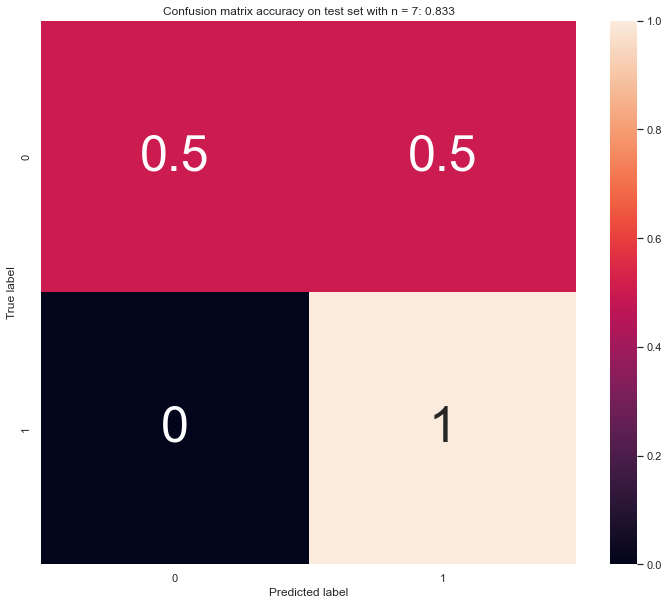

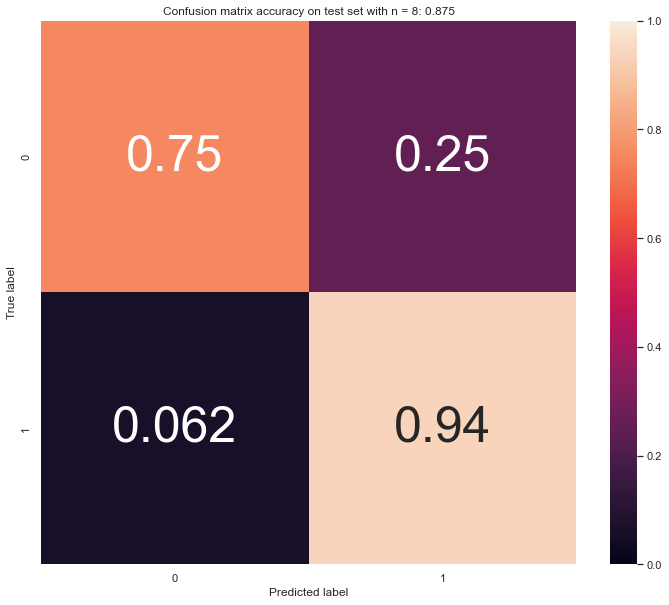

In [34]:
from itertools import product
n = [12,3,4,5,6,7,8]
for no in (n): # with product we can iterate through all possible combinations
    knn= KNeighborsClassifier(n_neighbors=no,
                              metric='minkowski', 
                              p=2)
    knn.fit(X_train, y_train)
    prediction_test = knn.predict(X=X_test)
    print('Classification accuracy on test set with n = {}: {:.3f}'.format(no, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with n = {}: {:.3f}'.format(no, accuracy_score(y_test,prediction_test)))

In [35]:
df=pd.DataFrame(data=glcm)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with n = 2: 0.583
Classification accuracy on test set with n = 3: 0.500
Classification accuracy on test set with n = 4: 0.583
Classification accuracy on test set with n = 5: 0.542
Classification accuracy on test set with n = 6: 0.625
Classification accuracy on test set with n = 7: 0.583
Classification accuracy on test set with n = 8: 0.667


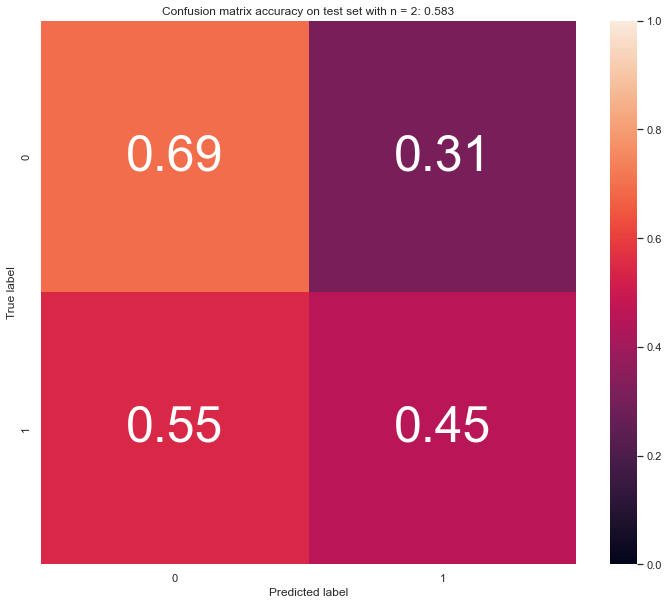

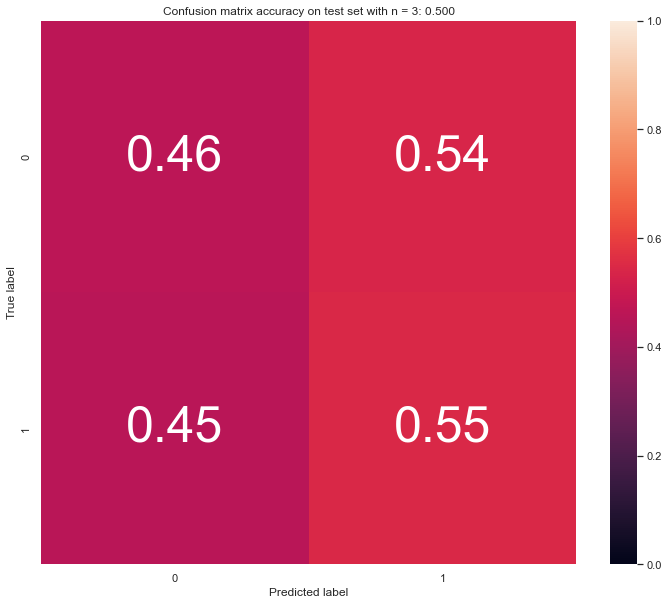

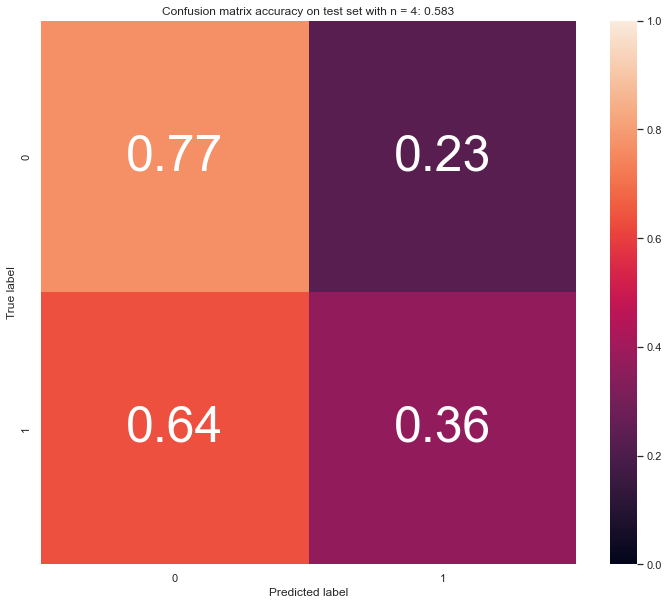

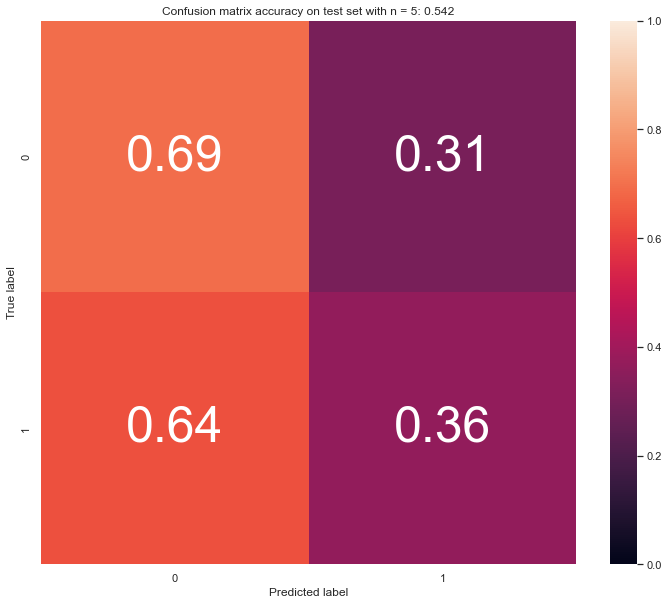

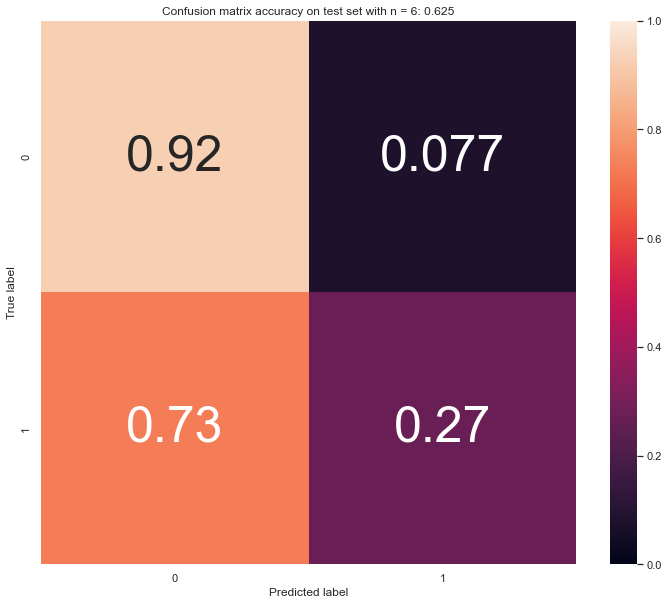

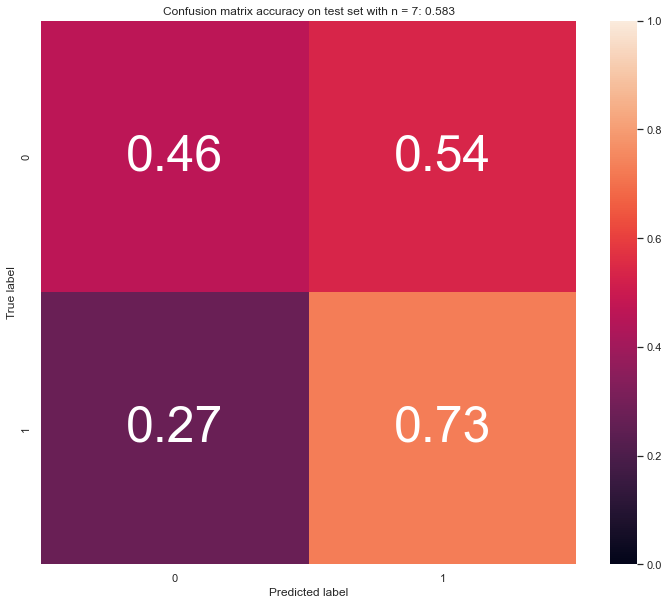

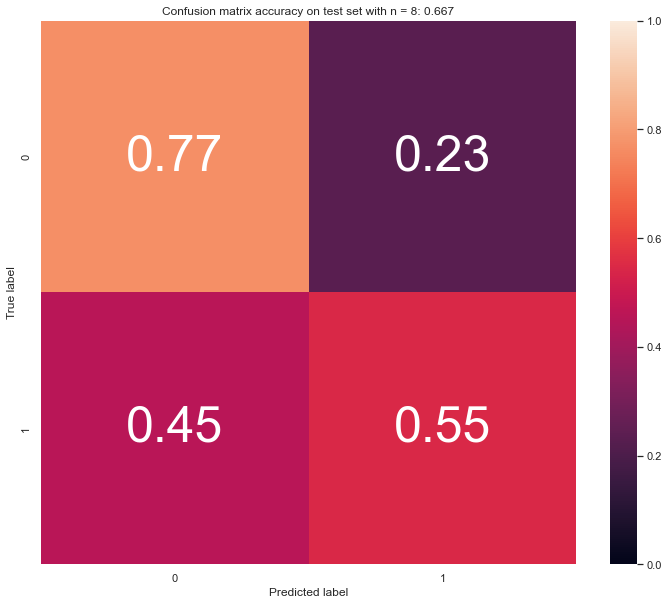

In [36]:
from itertools import product
n = [2,3,4,5,6,7,8]
for no in (n): # with product we can iterate through all possible combinations
    knn= KNeighborsClassifier(n_neighbors=no,
                              metric='minkowski', 
                              p=2)
    knn.fit(X_train, y_train)
    prediction_test = knn.predict(X=X_test)
    print('Classification accuracy on test set with n = {}: {:.3f}'.format(no, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with n = {}: {:.3f}'.format(no, accuracy_score(y_test,prediction_test)))

In [37]:
df=pd.DataFrame(data=images_sift_glcm)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with n = 2: 0.792
Classification accuracy on test set with n = 3: 0.708
Classification accuracy on test set with n = 4: 0.792
Classification accuracy on test set with n = 5: 0.792
Classification accuracy on test set with n = 6: 0.792
Classification accuracy on test set with n = 7: 0.625
Classification accuracy on test set with n = 8: 0.667


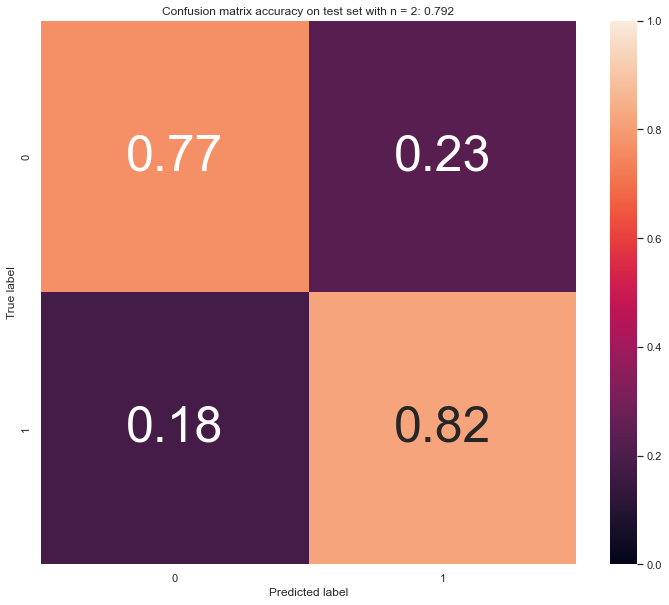

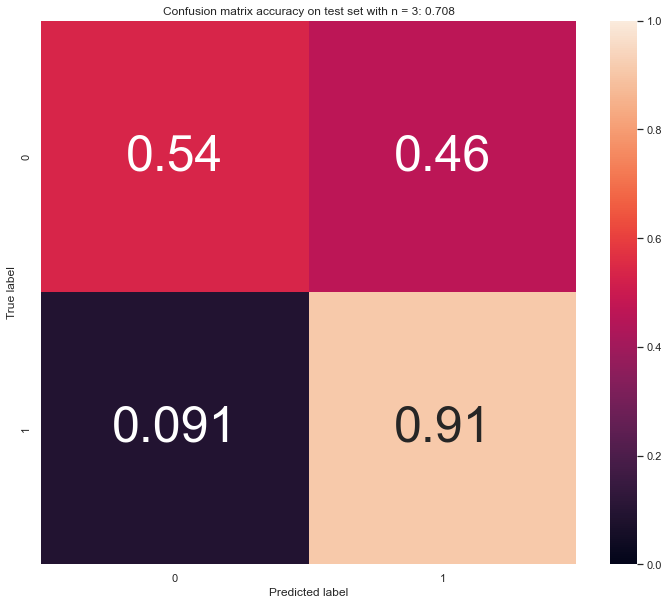

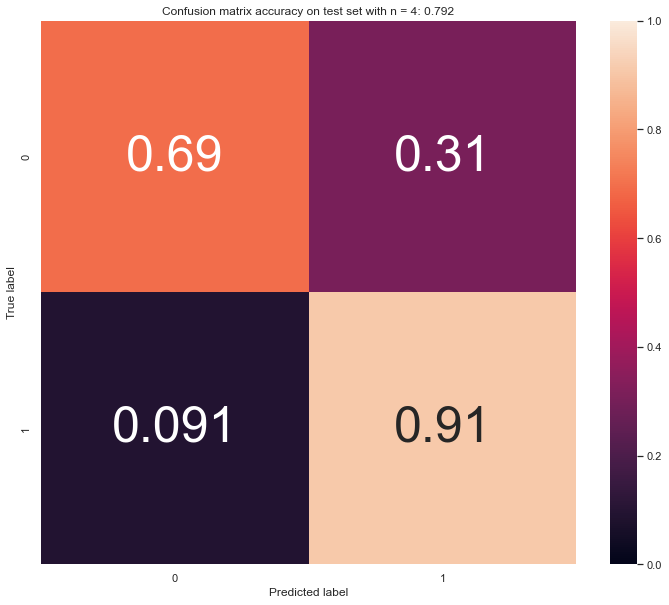

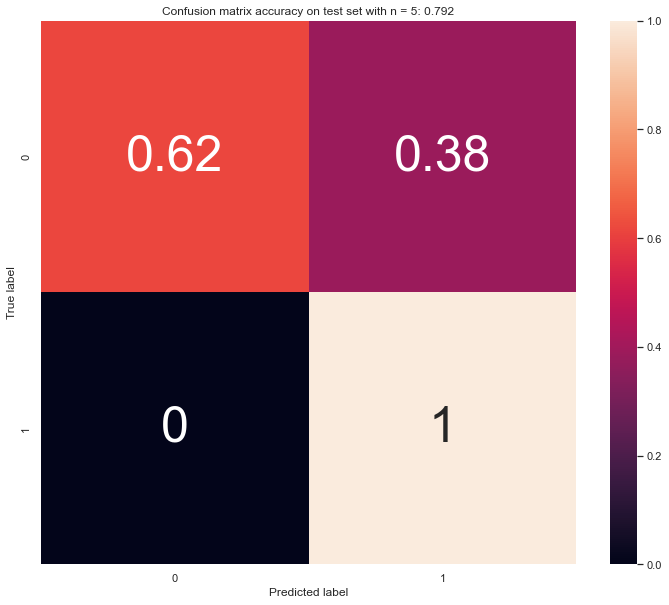

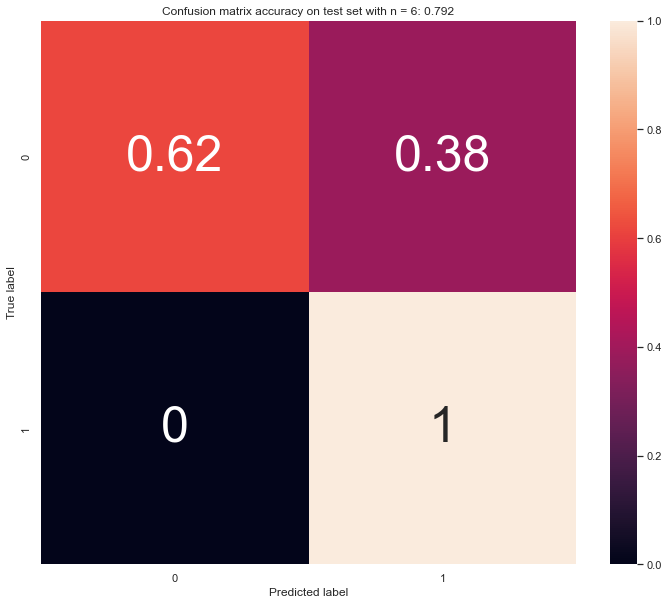

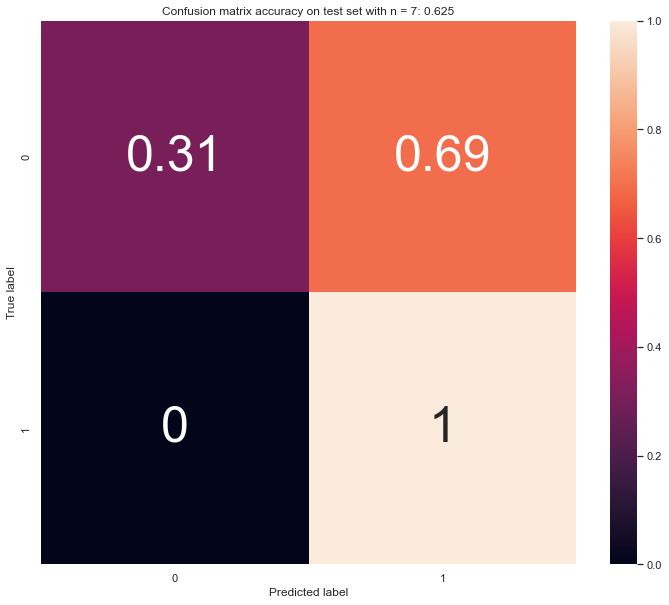

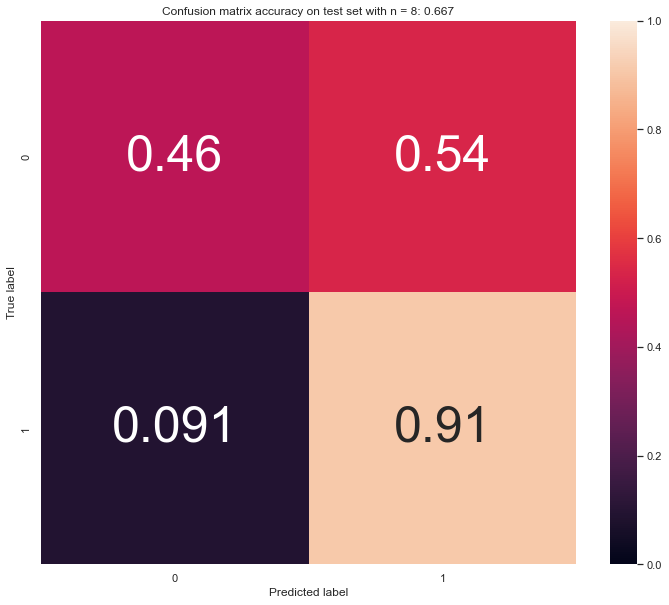

In [38]:
from itertools import product
n = [2,3,4,5,6,7,8]
for no in (n): # with product we can iterate through all possible combinations
    knn= KNeighborsClassifier(n_neighbors=no,
                              metric='minkowski', 
                              p=2)
    knn.fit(X_train, y_train)
    prediction_test = knn.predict(X=X_test)
    print('Classification accuracy on test set with n = {}: {:.3f}'.format(no, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with n = {}: {:.3f}'.format(no, accuracy_score(y_test,prediction_test)))

# Logistic Regression

In [39]:
df=pd.DataFrame(data=images_sift)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with solver = newton-cg and penalty = l2: 0.667
Classification accuracy on test set with solver = lbfgs and penalty = l2: 0.667
Classification accuracy on test set with solver = liblinear and penalty = l2: 0.667


c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Classification accuracy on test set with solver = sag and penalty = l2: 0.625
Classification accuracy on test set with solver = saga and penalty = l2: 0.667


c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


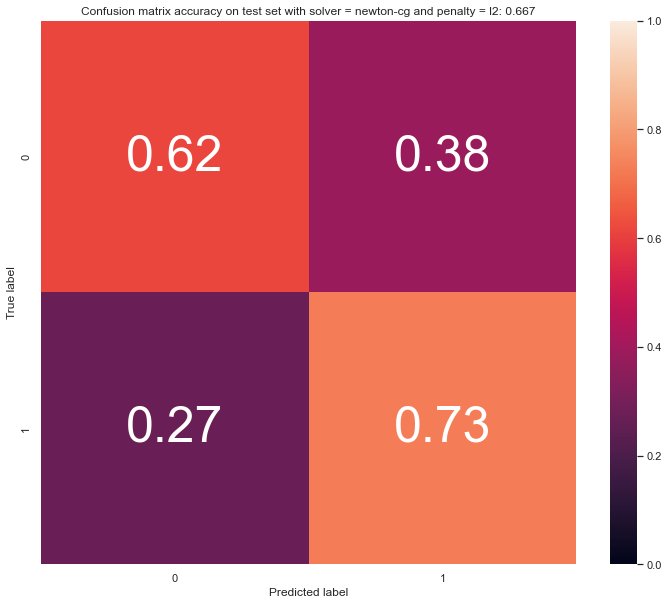

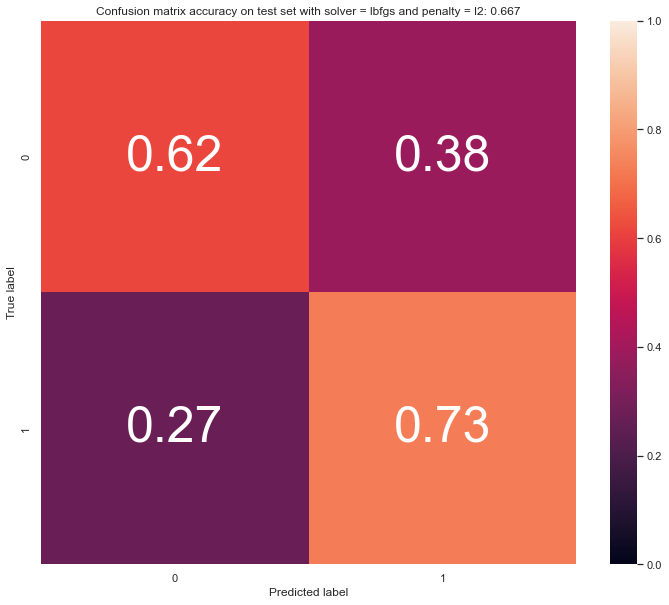

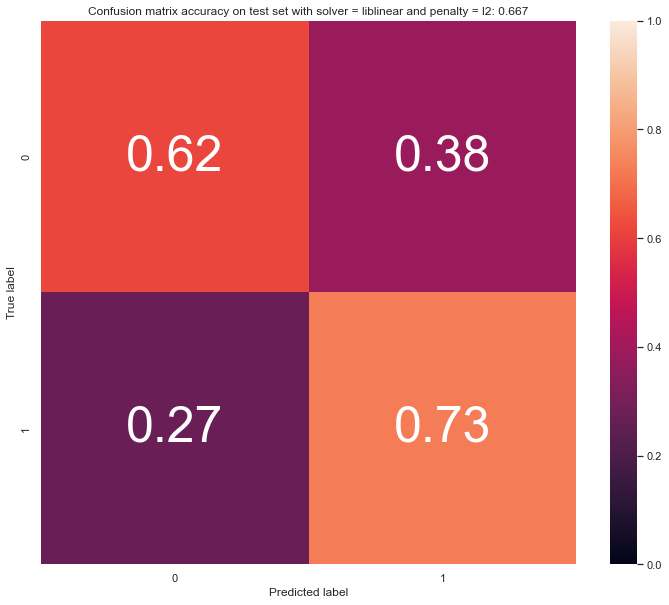

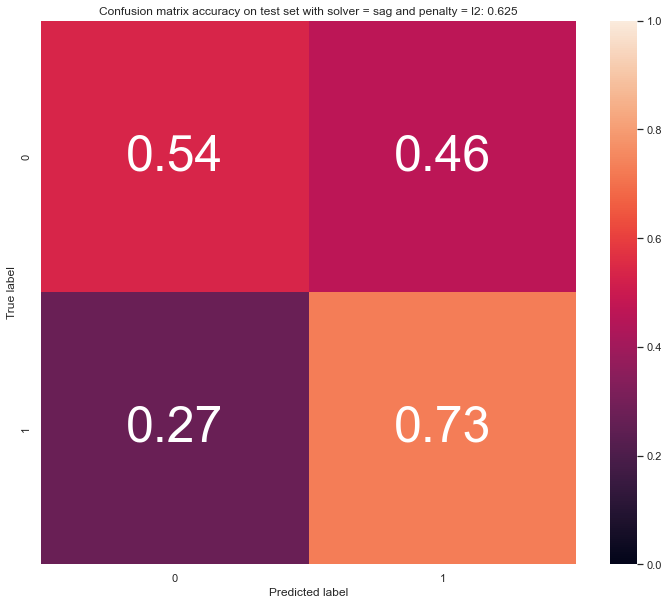

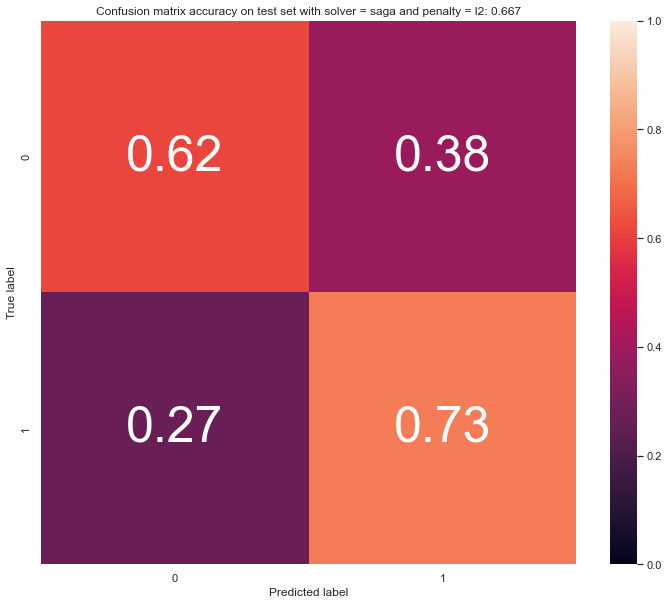

In [50]:
from itertools import product
solver = ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2']
#solver = ['saga']
#penalty = ['l1']
# solver = ['newton-cg','lbfgs','sag', 'saga']
# penalty = ['none']

for s,p in product(solver,penalty): # with product we can iterate through all possible combinations
    log = LogisticRegression(solver=s,
                             penalty=p)
    log.fit(X_train, y_train)
    prediction_test = log.predict(X=X_test)
    print('Classification accuracy on test set with solver = {} and penalty = {}: {:.3f}'.format(s, p, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with solver = {} and penalty = {}: {:.3f}'.format(s, p, accuracy_score(y_test,prediction_test)))

In [41]:
df=pd.DataFrame(data=glcm)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Classification accuracy on test set with solver = saga and penalty = l1: 0.417


c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


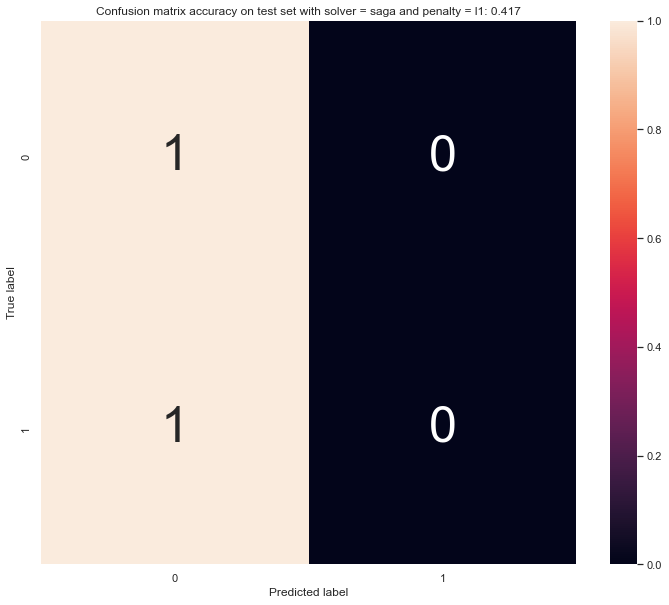

In [42]:
from itertools import product
#solver = ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']
#penalty = ['l2']
solver = ['saga']
penalty = ['l1']
#solver = ['newton-cg','lbfgs','sag', 'saga']
#penalty = ['none']

for s,p in product(solver,penalty): # with product we can iterate through all possible combinations
    log = LogisticRegression(solver=s,
                             penalty=p)
    log.fit(X_train, y_train)
    prediction_test = log.predict(X=X_test)
    print('Classification accuracy on test set with solver = {} and penalty = {}: {:.3f}'.format(s, p, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with solver = {} and penalty = {}: {:.3f}'.format(s, p, accuracy_score(y_test,prediction_test)))

# Cross-Validation

In [88]:
df=pd.DataFrame(data=images_sift)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=70)

In [89]:
from itertools import product
solver = ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2']
#solver = ['saga']
#penalty = ['l1']
# solver = ['newton-cg','lbfgs','sag', 'saga']
# penalty = ['none']

for s,p in product(solver,penalty): # with product we can iterate through all possible combinations
    log = LogisticRegression(solver=s,
                             penalty=p)
    log.fit(X_train, y_train)
    scores = cross_val_score(log, X_test, y_test, cv=5)
#     print("Logistic :",scores.mean())
    print('Cross Validation of Logistic with solver = {} and penalty = {}: {:.3f}'.format(s, p, scores.mean()))

Cross Validation of Logistic with solver = newton-cg and penalty = l2: 0.740
Cross Validation of Logistic with solver = lbfgs and penalty = l2: 0.740
Cross Validation of Logistic with solver = liblinear and penalty = l2: 0.790


c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gir

Cross Validation of Logistic with solver = sag and penalty = l2: 0.740


c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Cross Validation of Logistic with solver = saga and penalty = l2: 0.740


c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [90]:

rf_class = RandomForestClassifier(n_estimators=100, criterion='entropy',max_features='sqrt', max_depth=2, n_jobs=2,
random_state=1337)
# svm_poly=svm.SVC(kernel='poly',gamma=0.1,C=10)
knn= KNeighborsClassifier(n_neighbors=12, metric='minkowski', p=2) 
log = LogisticRegression(solver='saga',penalty='l1')


In [91]:
log.fit(X_train, y_train)
scores = cross_val_score(log, X_test, y_test, cv=5)
print("Logistic :",scores.mean())
rf_class.fit(X_train, y_train)
scores = cross_val_score(rf_class, X_test, y_test, cv=5)
print("rf_class :",scores.mean())

# svm_poly.fit(X_train, y_train)
# scores = cross_val_score(svm_poly, X_test, y_test, cv=5)
# print("svm_poly :",scores.mean())
knn.fit(X_train, y_train)
scores = cross_val_score(knn, X_test, y_test, cv=5)
print("knn :",scores.mean())

c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\girish\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gir

Logistic : 0.74
rf_class : 0.7500000000000001
knn : 0.61


# Bagging,Adaboost

In [46]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
model = BaggingClassifier(DecisionTreeClassifier(criterion="entropy",max_depth=8,random_state=42), max_samples=0.5, max_features=1.0,n_estimators = 20)
# model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",max_depth=30,random_state=42),n_estimators = 20)
model.fit(X_train,y_train)
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print('Bagging Classifier \tAccuracy: %.3f' % acc)
print(confusion_matrix(y_test, yhat))
print("\n\n")

Bagging Classifier 	Accuracy: 0.583
[[7 3]
 [7 7]]



